# Pylops - seismic interpolation

### Author: M.Ravasi

In this notebook I will implement and compare different ways to perform interpolation of seismic data onto a regular grid from data acquired by an irregularly sampled array of receivers.

The problem of seismic data interpolation is a very simple one, yet very ill-posed and hard to solve. Our forward modelling operator is a simple *restriction* or *sampling* operator which is applied along the spatial direction(s). 

$$\mathbf{y} = \mathbf{R} \mathbf{x}$$

where $\mathbf{y} = [\mathbf{y}_{R1}^T, \mathbf{y}_{R2}^T,..., \mathbf{y}_{RN^T}]^T$ and each vector  $\mathbf{y}_{Ri}$ contains all time samples recorded in the seismic data at the specific receiver $R_i$. Similarly, $\mathbf{x} = [\mathbf{x}_{r1}^T, \mathbf{x}_{r2}^T,..., \mathbf{x}_{rM}^T]$, contains all traces at the regularly and finely sampled idea array of receivers $r_i$.

The forward model simply selects a subset of sources/receivers from the input vector which is assumed to have a fine and regularly sampled array of receivers (which is what we wish to recover via inversion), while its adjoint places those values at the correct locations in the input vector. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.signal import convolve

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import FISTA

# 2D

## Linear events

In [2]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':140,
       'oy':0,'dy':2,    'ny':101,
       'ot':0,'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
theta_m = [0, 30, -60]
phi_m   = [0]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear2d(xaxis, taxis, v, t0_m, theta_m, amp_m, wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(dims=(par['nx'], par['nt']), iava=iava, axis=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=79.63290962496463 - u^H(Op^Hv)=79.63290962496458


### Inversion in time-space domain with spatial smoothing

Dot test passed, v^H(Opu)=43.8364088542578 - u^H(Op^Hv)=43.83640885425778


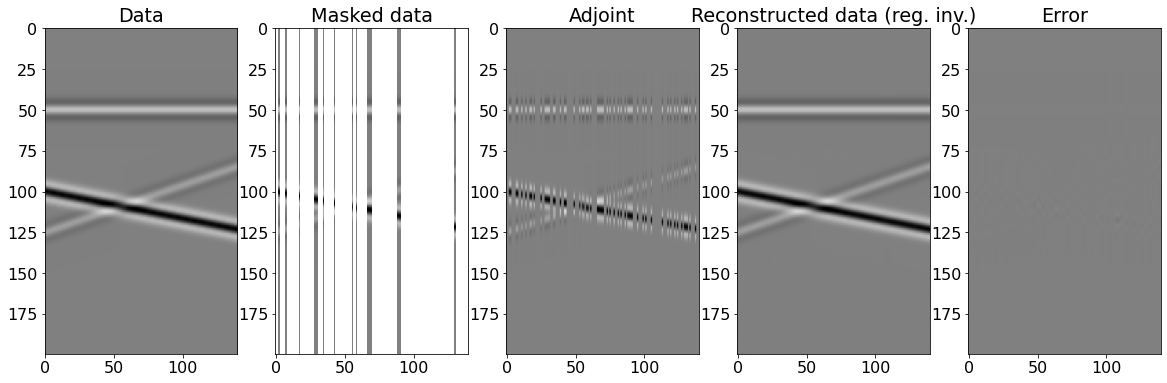

In [3]:
xinvf, _, _ = SeismicInterpolation(y, par['nx'], iava, kind='spatial', dottest=True,
                                   **dict(epsRs=[np.sqrt(0.1)],
                                          damp=np.sqrt(1e-4), 
                                          iter_lim=200 ,show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

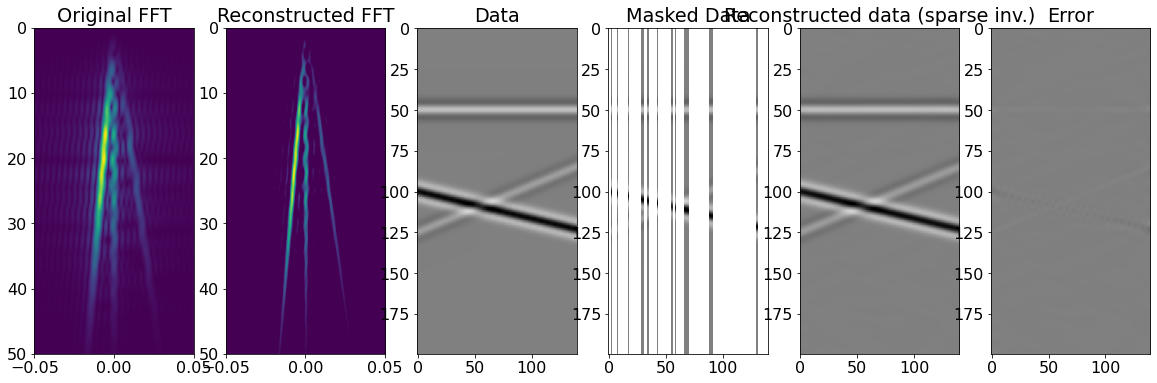

In [4]:
# FFT of full data
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

# Inverse
xinvf, pinvf, cost = SeismicInterpolation(y, par['nx'], iava, kind='fk', nffts=(nfft, nfft), 
                                          sampling=(par['dx'], par['dt']), dottest=False,
                                          **dict(niter=50, eps=1e-2))

fig, axs = plt.subplots(1, 6, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pinvf[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked Data')
axs[3].axis('tight');
axs[4].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

### Inversion in linear Radon domain with sparsity-promoting solver

First we just setup and apply Radon to the full data

Dot test passed, v^H(Opu)=1611.2761644583802 - u^H(Op^Hv)=1611.2761644583804


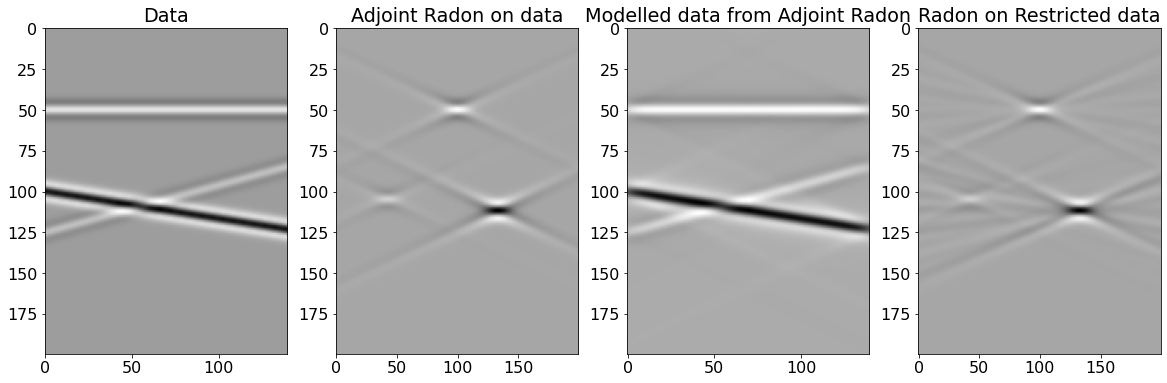

In [5]:
npx=200
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

Then we apply sparse inversion

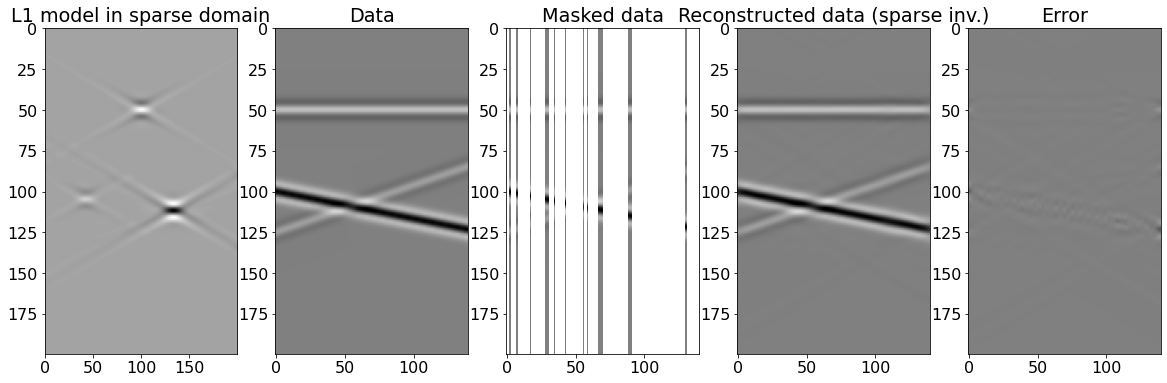

In [6]:
xinvf, pinvf, cost = SeismicInterpolation(y, par['nx'], iava, kind='radon-linear', spataxis=xaxis, 
                                          taxis=taxis, paxis=px, centeredh=True, dottest=False,
                                          **dict(niter=20, eps=5e-1))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pinvf.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

## Parabolic events

In [7]:
###### Input parameters
par = {'ox':0, 'dx':2,    'nx':140,
       'oy':0, 'dy':2,    'ny':100,
       'ot':0, 'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
px_m = [0, 0, 0]
pxx_m = [1e-5, 5e-6, 1e-6]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
_, x =  parabolic2d(xaxis, taxis, t0_m, px_m, pxx_m,amp_m,wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(dims=(par['nx'], par['nt']), iava=iava, axis=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=202.08318782618193 - u^H(Op^Hv)=202.08318782618193


### Inversion in time-space domain with spatial smoothing

Dot test passed, v^H(Opu)=-10.838554368852991 - u^H(Op^Hv)=-10.838554368852984


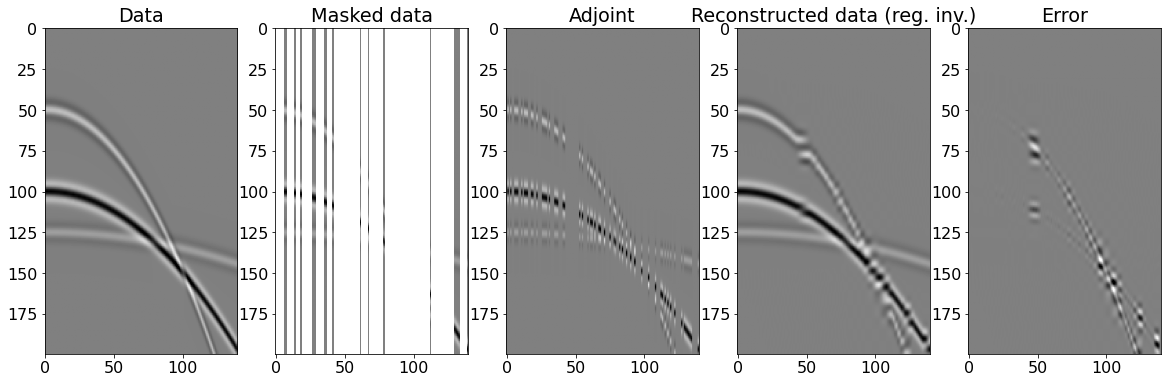

In [8]:
xinvf, _, _ = SeismicInterpolation(y, par['nx'], iava, kind='spatial', dottest=True,
                                   **dict(epsRs=[np.sqrt(0.1)],
                                          damp=np.sqrt(1e-4), 
                                          iter_lim=200 ,show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

Dot test passed, v^H(Opu)=(-80.72524423973834+22.332807508284517j) - u^H(Op^Hv)=(-80.72524423973834+22.33280750828453j)


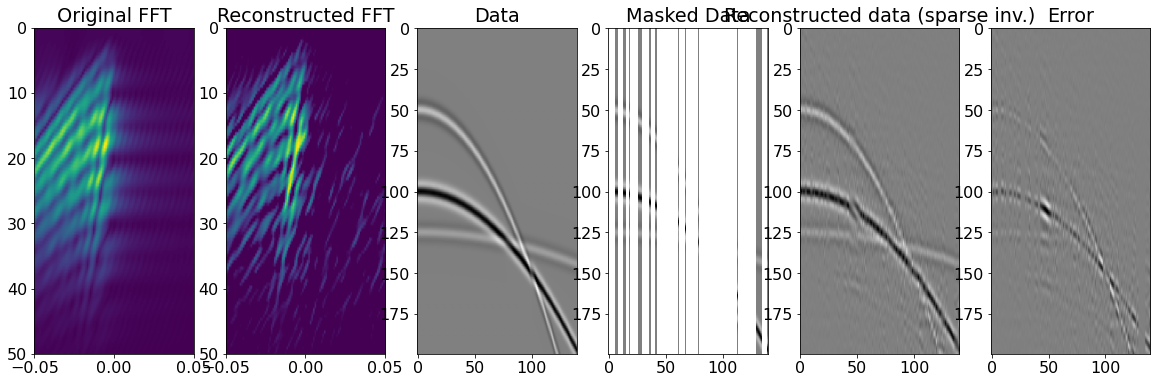

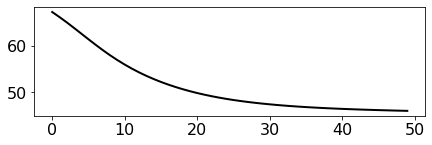

In [9]:
# FFT of full data
nfft=2**9
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

# Inverse
xinvf, pinvf, cost = SeismicInterpolation(y, par['nx'], iava, kind='fk', nffts=(nfft, nfft), 
                                          sampling=(par['dx'], par['dt']), dottest=True,
                                          **dict(niter=50, eps=1e-2))

fig, axs = plt.subplots(1, 6, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pinvf[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked Data')
axs[3].axis('tight');
axs[4].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in parabolic Radon domain with sparsity-promoting solver

First we just setup and apply Radon to the full data

Dot test passed, v^H(Opu)=-635.8776085025419 - u^H(Op^Hv)=-635.8776085025431


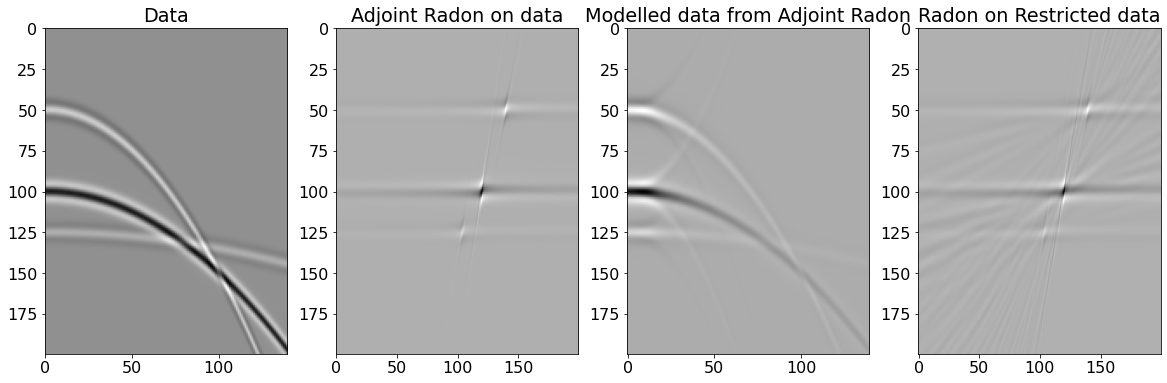

In [10]:
npx=200
pxmax = 5e-5
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=False, kind='parabolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

Then we apply sparse inversion

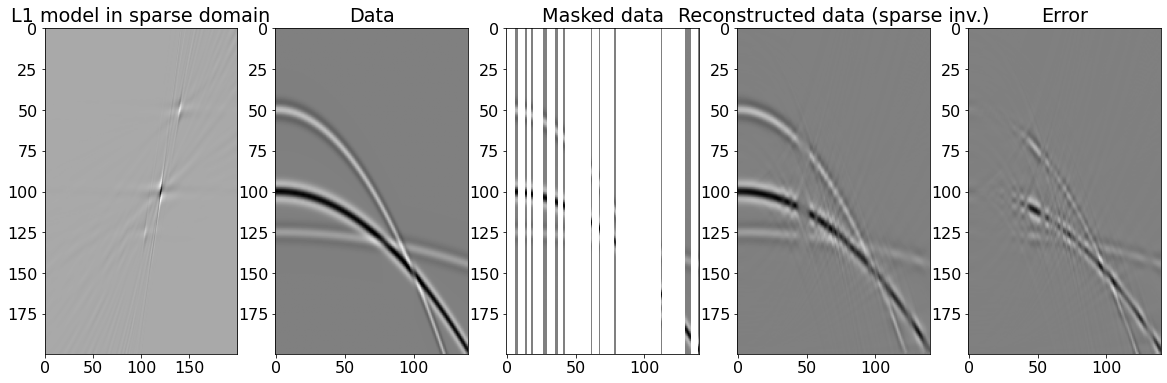

In [11]:
xinvf, pinvf, _ = SeismicInterpolation(y, par['nx'], iava, kind='radon-parabolic', spataxis=xaxis, 
                                       taxis=taxis, paxis=px, centeredh=False, dottest=False,
                                       **dict(niter=20, eps=5e-1))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pinvf.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in sliding linear Radon domain with sparsity-promoting solver

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 11200 rows and 97600 cols
eps = 7.000000e-01	tol = 1.000000e-10	niter = 40
alpha = 1.591707e-03	thresh = 5.570976e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -0.0000e+00         4.022e+02   4.260e+02   3.941e-01
     2       0.0000e+00         3.288e+02   3.720e+02   3.310e-01
     3       0.0000e+00         2.597e+02   3.235e+02   3.626e-01
     4       0.0000e+00         2.004e+02   2.842e+02   3.709e-01
     5       0.0000e+00         1.524e+02   2.547e+02   3.628e-01
     6       0.0000e+00         1.154e+02   2.336e+02   3.442e-01
     7       0.0000e+00         8.762e+01   2.191e+02   3.198e-01
     8       0.0000e+00         6.725e+01   2.091e+02   2.930e-01
     9       0.0000e+00         5.252e+01   2.021e+02   2.664e-01
    10       0.

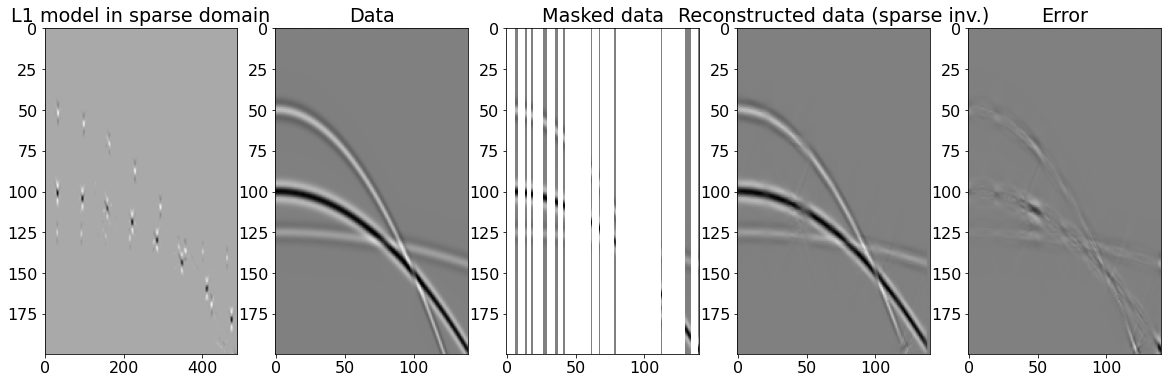

In [12]:
nwin = 26
nwins = 8
nover = 10
npx = 61
px = np.linspace(-5e-3, 5e-3, npx)
dimsd = x.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon with overlap
Op = Radon2D(taxis, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), px, centeredh=True,
             kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims))

Rop1 = Rop*Slidop

# adjoint
padj = Rop1.H*y.flatten()
padj = padj.reshape(npx*nwins, par['nt'])

# inverse
xinvf, pinvf, _ = SeismicInterpolation(y, par['nx'], iava, kind='sliding', spataxis=xaxis, 
                                    taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                    nover=nover, dottest=False,
                                    **dict(niter=40, eps=7e-1, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pinvf.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

## Realistic data

In [13]:
inputfile = '../../pylops/testdata/marchenko/input.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = 0.3*inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# subsampling locations
perc_subsampling=0.6
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(dims=(par['nx'], par['nt']), iava=iava, axis=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=-227.93799826970462 - u^H(Op^Hv)=-227.93799826970456


### Inversion in time-space domain with spatial smoothing

Dot test passed, v^H(Opu)=156.75604532636754 - u^H(Op^Hv)=156.75604532636748


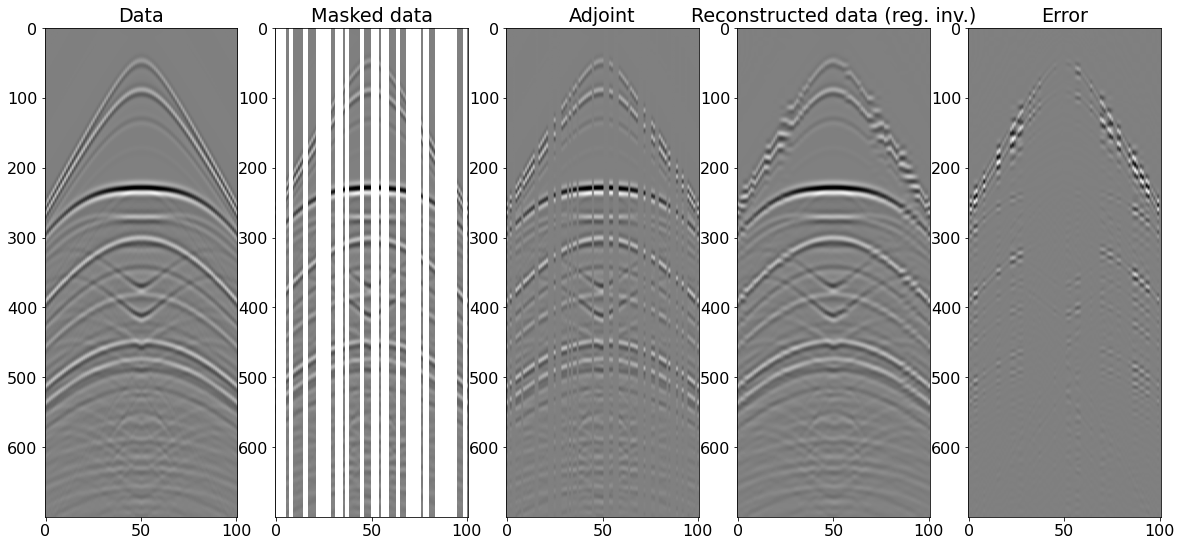

In [14]:
xinv, _, _ = SeismicInterpolation(y, par['nx'], iava, kind='spatial', dottest=True,
                               **dict(epsRs=[np.sqrt(0.1)],
                                      damp=np.sqrt(1e-4), 
                                      iter_lim=200, show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

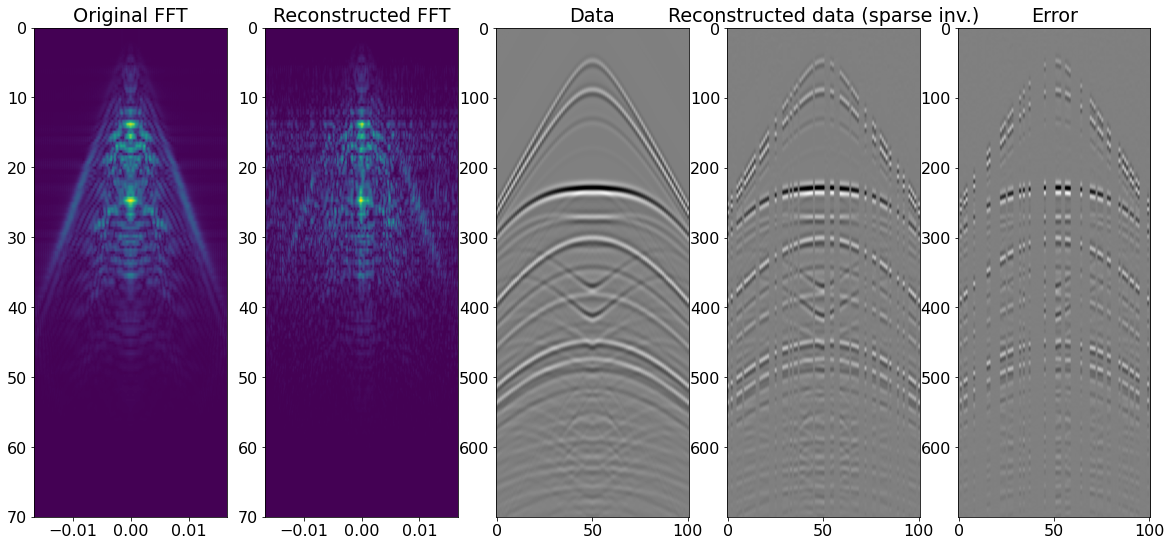

In [15]:
# FFT of full data
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

pmask = FFTop*x.flatten()
pmask = np.reshape(p, (nfft, nfft))


# Inverse
xinv, pinv, _ = SeismicInterpolation(y, par['nx'], iava, kind='fk', nffts=(nfft, nfft), 
                                     sampling=(par['dx'], par['dt']), dottest=False,
                                     **dict(niter=100, eps=1e-6, show=False))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
axs[1].imshow(np.fft.fftshift(np.abs(pinv[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(70, 0)
axs[2].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in parabolic Radon domain with sparsity-promoting solver

Dot test passed, v^H(Opu)=3484.8552035319367 - u^H(Op^Hv)=3484.8552035319353
FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 42700 rows and 140700 cols
eps = 4.000000e-02	tol = 1.000000e-10	niter = 50
alpha = 1.000000e-04	thresh = 2.000000e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         9.032e-01   9.178e-01   2.461e-03
     2      -0.0000e+00         8.453e-01   8.731e-01   2.301e-03
     3      -0.0000e+00         7.799e-01   8.235e-01   2.768e-03
     4      -0.0000e+00         7.114e-01   7.723e-01   3.130e-03
     5      -0.0000e+00         6.431e-01   7.223e-01   3.399e-03
     6      -0.0000e+00         5.774e-01   6.752e-01   3.587e-03
     7      -0.0000e+00         5.159e-01   6.322e-01   3.709e-03
     8      -0.0000e+00         4.592e-01   5.936e-01   3.774e-03
   

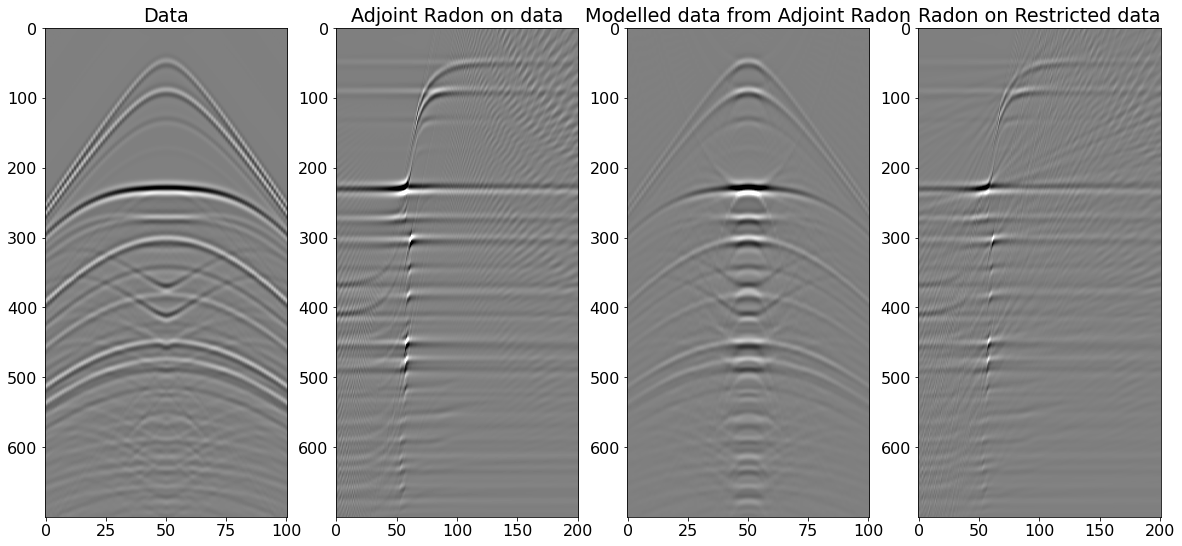

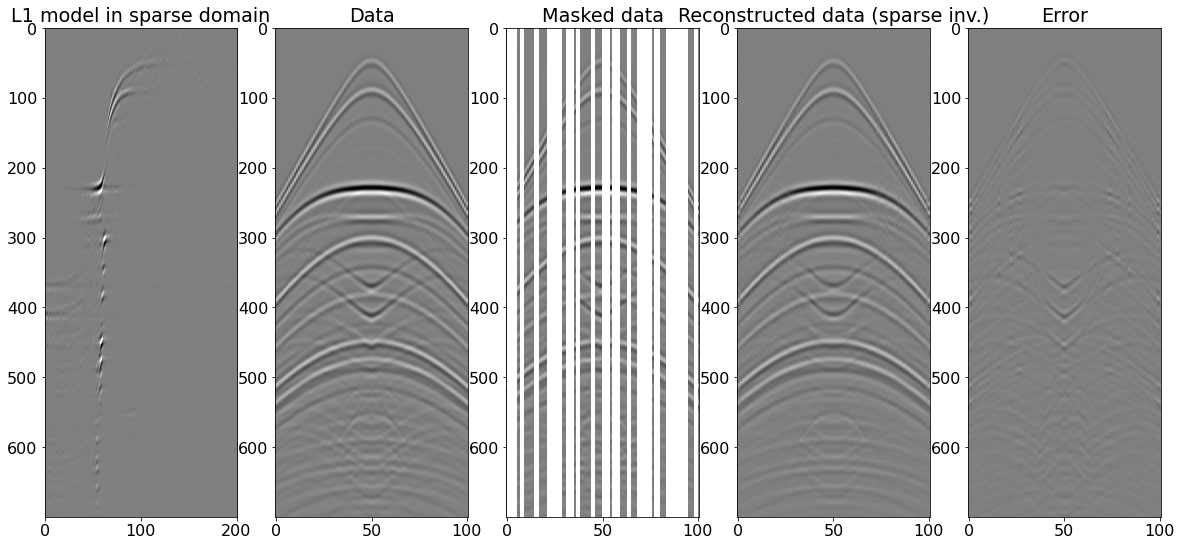

In [16]:
npx=201
pxmax = 4e-5
px = np.linspace(-pxmax/3, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=True, kind='parabolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray', vmin=-50, vmax=50)
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray', vmin=-1, vmax=1)
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

# Sparse inversion
xinv, pinv, _ = SeismicInterpolation(y, par['nx'], iava, kind='radon-parabolic', spataxis=xaxis, 
                                     taxis=taxis, paxis=px, centeredh=True, dottest=False,
                                     **dict(niter=50, eps=4e-2, alpha=1e-4, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(pinv.T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in hyperbolic Radon domain with sparsity-promoting solver

Dot test passed, v^H(Opu)=2692.44441890374 - u^H(Op^Hv)=2692.444418903739
FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 42700 rows and 140700 cols
eps = 4.000000e-02	tol = 1.000000e-10	niter = 50
alpha = 8.535772e-05	thresh = 1.707154e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         7.584e-01   7.845e-01   4.415e-03
     2       0.0000e+00         6.372e-01   6.819e-01   3.278e-03
     3       0.0000e+00         5.387e-01   6.012e-01   3.322e-03
     4       0.0000e+00         4.603e-01   5.388e-01   3.257e-03
     5       0.0000e+00         3.961e-01   4.885e-01   3.192e-03
     6       0.0000e+00         3.415e-01   4.463e-01   3.154e-03
     7       0.0000e+00         2.943e-01   4.098e-01   3.129e-03
     8       0.0000e+00         2.533e-01   3.782e-01   3.099e-03
     9

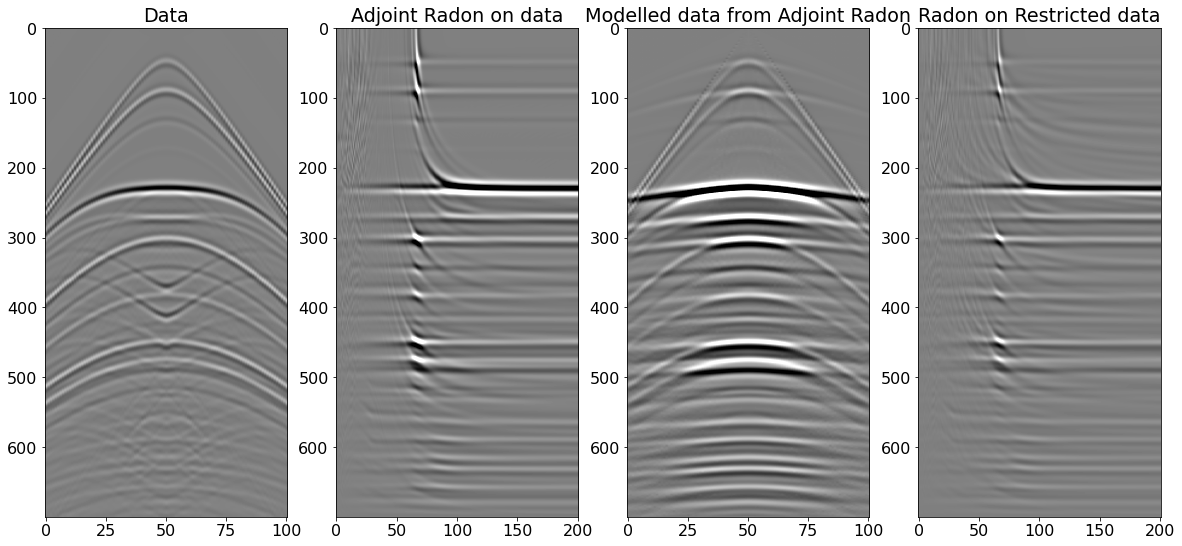

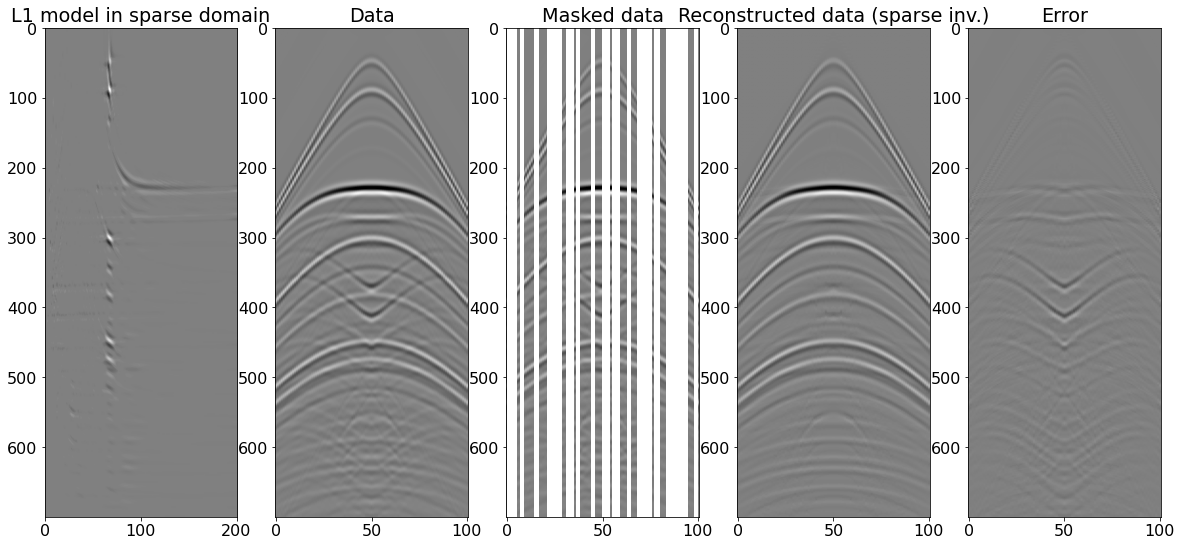

In [17]:
npx=201
pxmax = 5e-5
px = np.linspace(0, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=True, kind='hyperbolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray', vmin=-50, vmax=50)
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray', vmin=-1, vmax=1)
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

# Sparse inversion
xinv, pinv, _ = SeismicInterpolation(y, par['nx'], iava, kind='radon-hyperbolic', spataxis=xaxis, 
                                     taxis=taxis, paxis=px, centeredh=True, dottest=False,
                                     **dict(niter=50, eps=4e-2, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(pinv.T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in sliding linear Radon domain with sparsity-promoting solver

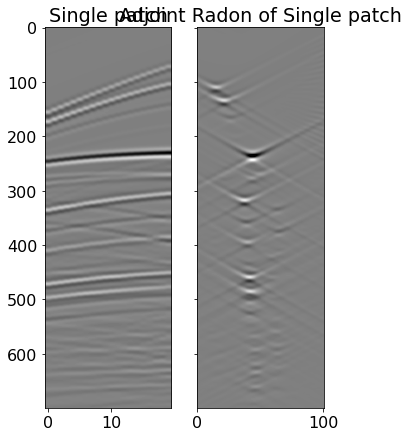

In [18]:
dx = par['dx']
nwin=20
nwins=9
nover=10
npx=101
pxmax = 5e-4
px = np.linspace(-pxmax, pxmax, npx)
dimsd = x.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon with overlap
Op = Radon2D(taxis, np.linspace(-dx*nwin//2, dx*nwin//2, nwin), px, centeredh=True,
             kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims))

# radon on one patch
x1 = x[1*nwin:2*nwin]
y1 = Op.H*x1.flatten()
y1 = y1.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5, 7))
axs[0].imshow(x1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].axis('tight')
axs[0].set_title('Single patch')

axs[1].imshow(y1.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].axis('tight')
axs[1].set_title('Adjoint Radon of Single patch');

Dot test passed, v^H(Opu)=2056.586030864625 - u^H(Op^Hv)=2056.5860308646297
FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 42700 rows and 636300 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 50
alpha = 1.200000e-03	thresh = 3.000000e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         7.482e-01   7.765e-01   1.642e-02
     2       0.0000e+00         5.887e-01   6.403e-01   1.385e-02
     3       0.0000e+00         4.407e-01   5.172e-01   1.514e-02
     4       0.0000e+00         3.169e-01   4.179e-01   1.537e-02
     5       0.0000e+00         2.212e-01   3.449e-01   1.483e-02
     6       0.0000e+00         1.517e-01   2.954e-01   1.376e-02
     7       0.0000e+00         1.037e-01   2.643e-01   1.238e-02
     8       0.0000e+00         7.197e-02   2.461e-01   1.087e-02
    

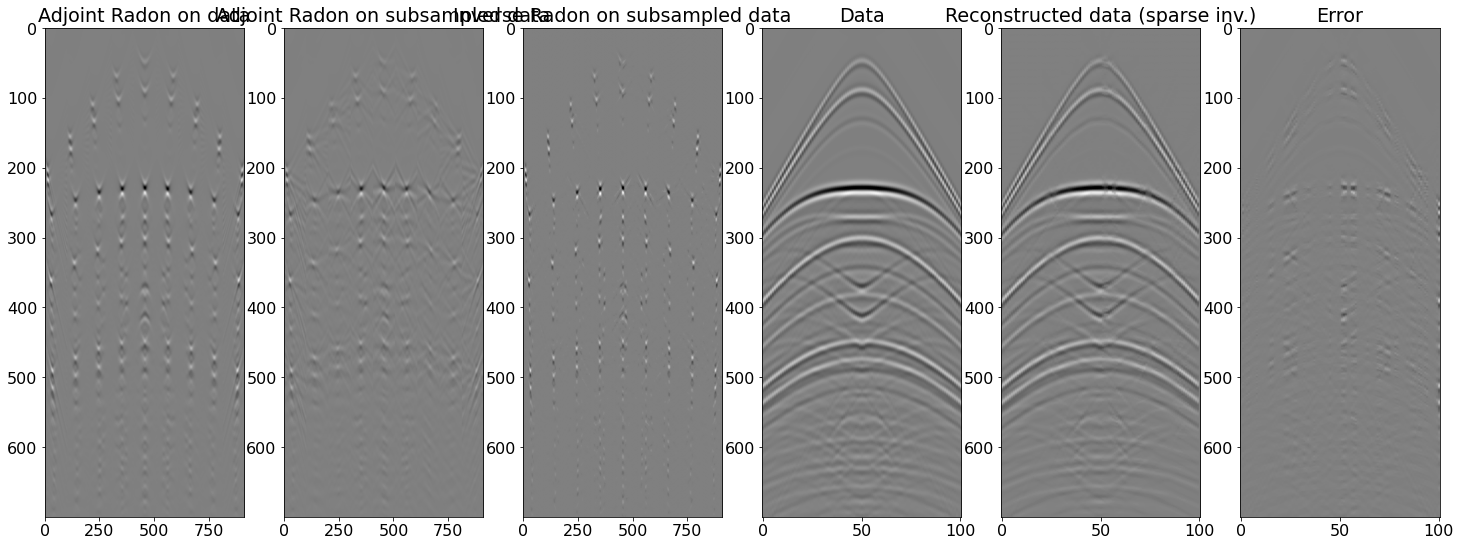

In [19]:
# adjoint
Rop1 = Rop*Slidop

padj_fromx = Slidop.H*x.flatten()
padj_fromx = padj_fromx.reshape(npx*nwins, par['nt'])

padj = Rop1.H*y.flatten()
padj = padj.reshape(npx*nwins, par['nt'])

# inverse
xinv, pinv, _ = SeismicInterpolation(y, par['nx'], iava, kind='sliding', spataxis=xaxis, 
                                     taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                     nover=nover, dottest=True,
                                     **dict(niter=50, eps=5e-3, alpha=1.2e-3, 
                                            show=True))

fig, axs = plt.subplots(1, 6, figsize=(25, 9))
axs[0].imshow(padj_fromx.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[0].set_title('Adjoint Radon on data')
axs[0].axis('tight')
axs[1].imshow(padj.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].set_title('Adjoint Radon on subsampled data')
axs[1].axis('tight')
axs[2].imshow(pinv.T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Inverse Radon on subsampled data')
axs[2].axis('tight')
axs[3].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight')
axs[5].imshow(x.T-xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Error')
axs[5].axis('tight');

# 3D

## Linear events

In [20]:
###### Input parameters
par = {'oy':0,'dy':2,    'ny':51,
       'ox':0,'dx':2,    'nx':30,
       'ot':0,'dt':0.004,'nt':100,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.1, 0.2, 0.3]
theta_m = [0, 30, -60]
phi_m   = [0, 50, 30]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear3d(xaxis, yaxis, taxis, v, t0_m, theta_m, phi_m, amp_m, wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['ny']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['ny']))[:Nsub])

# Create restriction operator
Rop = Restriction(dims=(par['ny'], par['nx'], par['nt']), iava=iava, 
                  axis=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=-127.44789164178434 - u^H(Op^Hv)=-127.4478916417844


### Inversion in time-space domain with spatial smoothing

Dot test passed, v^H(Opu)=311.6057167437747 - u^H(Op^Hv)=311.60571674377485


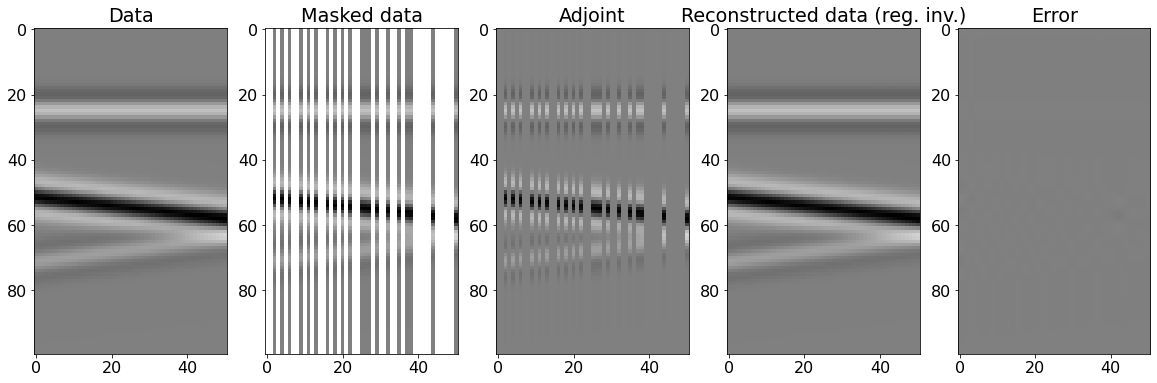

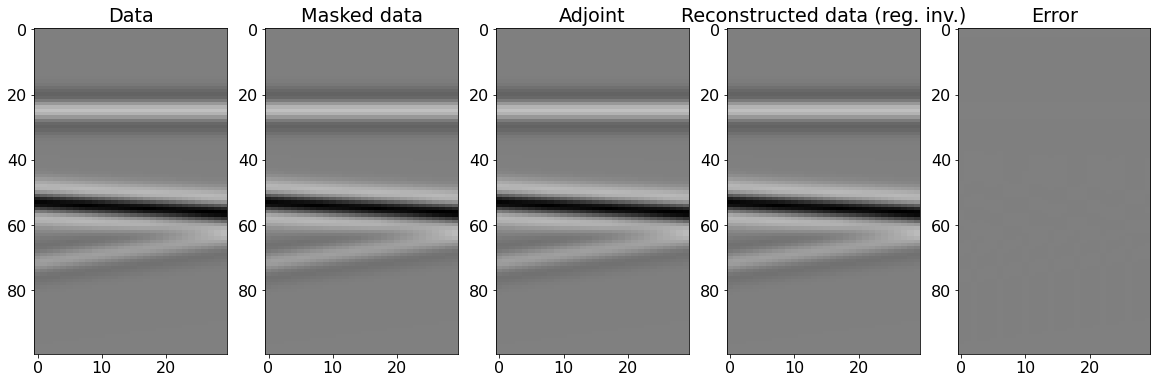

In [21]:
# Invert for interpolated signal
xinv, _, _ = SeismicInterpolation(y, (par['ny'], par['nx']), iava, kind='spatial', dottest=True,
                                  **dict(epsRs=[np.sqrt(0.1)],
                                         damp=np.sqrt(1e-4), iter_lim=100, show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[par['ny']//2].T-xinv[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

Dot test passed, v^H(Opu)=(-222.54679067599946+352.4645904081261j) - u^H(Op^Hv)=(-222.5467906760012+352.4645904081221j)
FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 60000 rows and 2097152 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 50
alpha = 1.000000e+00	thresh = 5.000000e-02
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    1.213e+02   1.579e+03   9.736e+01
     2   0.00e+00+0.00e+00j    8.934e+01   1.430e+03   9.219e+00
     3   -0.00e+00+0.00e+00j    7.052e+01   1.319e+03   8.908e+00
     4   -0.00e+00+0.00e+00j    5.882e+01   1.230e+03   8.704e+00
     5   -0.00e+00+0.00e+00j    5.111e+01   1.156e+03   8.561e+00
     6   -0.00e+00+0.00e+00j    4.564e+01   1.093e+03   8.422e+00
     7   -0.00e+00+0.00e+00j    4.148e+01   1.038e+03   8.286e+00
     8   -0.00e+00+0.00e+00

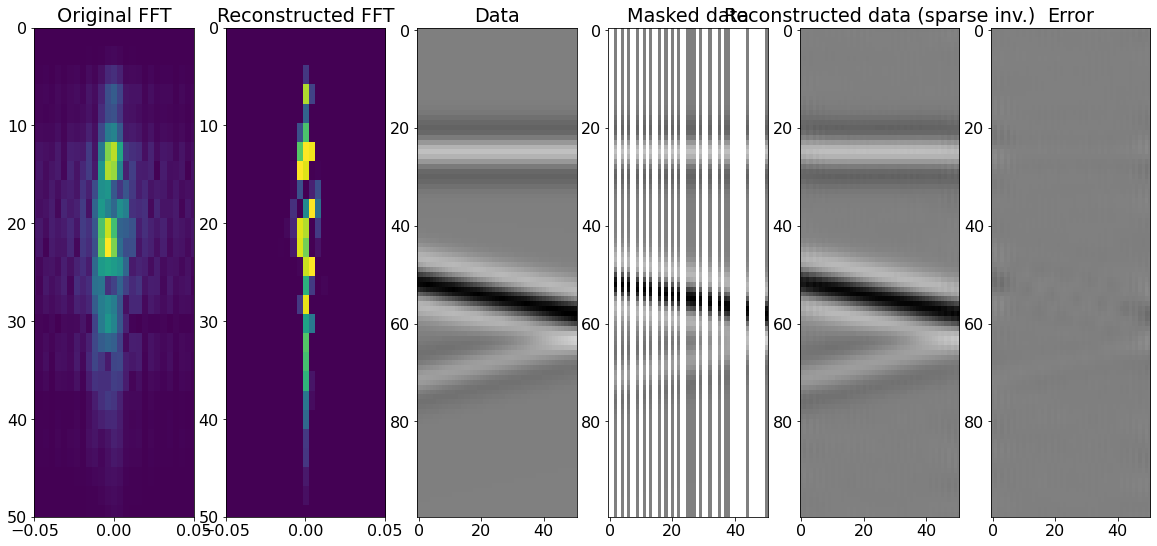

In [22]:
nfft=2**7
FFTop = FFTND(dims=[par['ny'], par['nx'], par['nt']], nffts=[nfft, nfft, nfft], 
              sampling=[par['dy'], par['dx'], par['dt']])
dottest(FFTop, nfft*nfft*nfft, par['ny']*par['nx']*par['nt'], complexflag=2, verb=True)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft, nfft))

# Inverse
xinv, pinv, _ = SeismicInterpolation(y, (par['ny'], par['nx']), iava, kind='fk', nffts=(nfft, nfft, nfft), 
                                     sampling=(par['dy'], par['dx'], par['dt']), dottest=False,
                                     **dict(niter=50, eps=1e-1, alpha=1e0, show=True))

fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, 1, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=10)
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pinv[:, 1, :nfft//2-1]), axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=10)
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked data')
axs[3].axis('tight')
axs[4].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

### Inversion in linear Radon domain with sparsity-promoting solver

Dot test passed, v^H(Opu)=7171.154407169666 - u^H(Op^Hv)=7171.154407169621


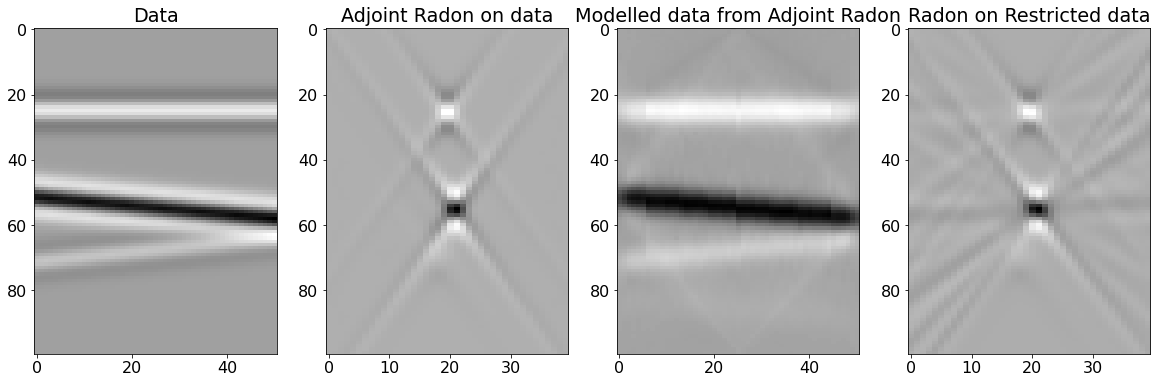

In [23]:
npx=40
pxmax = 4e-3
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon3D(taxis, yaxis, xaxis, px, px, engine='numba', interp=False)
dottest(Radop, par['ny']*par['nx']*par['nt'], npx*npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['ny'], par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj[:, npx//2].T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj[:, par['nx']//2].T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj[:, npx//2].T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 60000 rows and 160000 cols
eps = 5.000000e+01	tol = 1.000000e-10	niter = 50
alpha = 1.360000e-06	thresh = 3.400000e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         5.589e+03   5.618e+03   1.092e-02
     2       0.0000e+00         5.491e+03   5.549e+03   1.072e-02
     3       0.0000e+00         5.370e+03   5.463e+03   1.350e-02
     4       0.0000e+00         5.229e+03   5.364e+03   1.605e-02
     5       0.0000e+00         5.072e+03   5.253e+03   1.841e-02
     6       0.0000e+00         4.902e+03   5.134e+03   2.058e-02
     7       0.0000e+00         4.721e+03   5.008e+03   2.257e-02
     8       0.0000e+00         4.532e+03   4.876e+03   2.438e-02
     9       0.0000e+00         4.339e+03   4.742e+03   2.602e-02
    10       0

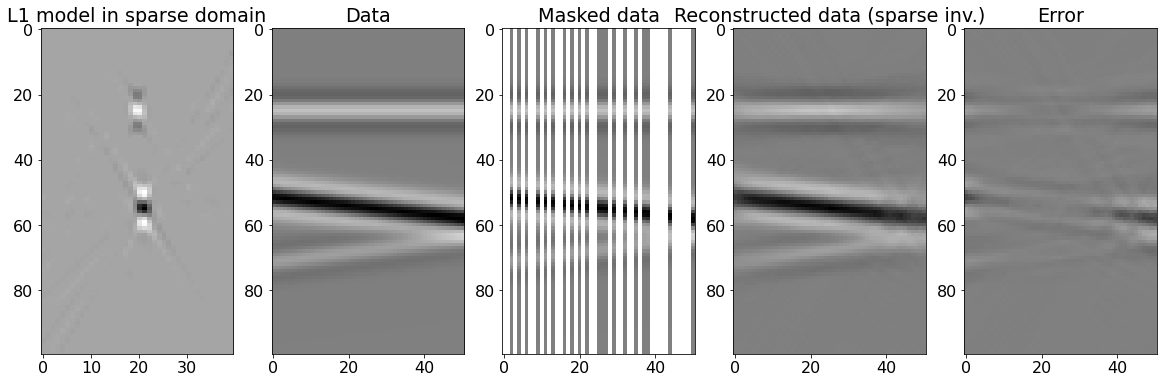

In [24]:
xinv, pinv, _ = SeismicInterpolation(y, (par['ny'], par['nx']), 
                                     iava, kind='radon-linear', spataxis=yaxis, spat1axis=xaxis, 
                                     taxis=taxis, paxis=px, p1axis=px, centeredh=True, dottest=False,
                                     **dict(niter=50, eps=5e1, alpha=1.36e-6, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pinv[:, npx//2].T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in sliding linear Radon domain with sparsity-promoting solver

In [25]:
dy = par['dy']
dx = par['dx']
nwin=(24, 11)
nwins=(2, 3)
nover=(2, 3)
npy=41
npx=41
pxmax = 5e-3
py = px = np.linspace(-pxmax, pxmax, npx)
dimsd = (par['ny'], par['nx'], par['nt'])
dims = (nwins[0]*npy, nwins[1]*npx, dimsd[2])

# sliding window radon with overlap
Op = Radon3D(taxis, np.linspace(-dy*nwin[0]//2, dy*nwin[0]//2, nwin[0]), 
             np.linspace(-dx*nwin[1]//2, dx*nwin[1]//2, nwin[1]), 
             px, px, centeredh=True, kind='linear', engine='numba')
Slidop = Sliding3D(Op, dims, dimsd, nwin, nover, (npy, npx), tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims), verb=True)

# adjoint
Rop1 = Rop*Slidop

padj_fromx = Slidop.H*x.flatten()
padj_fromx = padj_fromx.reshape(nwins[0], nwins[1], npy, npx, par['nt'])

padj = Rop1.H*y.flatten()
padj = padj.reshape(nwins[0], nwins[1], npy, npx, par['nt'])

Dot test passed, v^H(Opu)=3141.8709020470806 - u^H(Op^Hv)=3141.8709020470906


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 60000 rows and 1008600 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 40
alpha = 1.000000e-05	thresh = 2.500000e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         5.324e+03   5.418e+03   5.782e-02
     2       0.0000e+00         5.015e+03   5.190e+03   5.285e-02
     3       0.0000e+00         4.677e+03   4.942e+03   6.269e-02
     4       0.0000e+00         4.331e+03   4.691e+03   7.011e-02
     5      -0.0000e+00         3.993e+03   4.448e+03   7.549e-02
     6      -0.0000e+00         3.673e+03   4.222e+03   7.915e-02
     7      -0.0000e+00         3.377e+03   4.017e+03   8.138e-02
     8      -0.0000e+00         3.109e+03   3.833e+03   8.243e-02
     9       0.0000e+00         2.869e+03   3.671e+03   8.252e-02
    10       

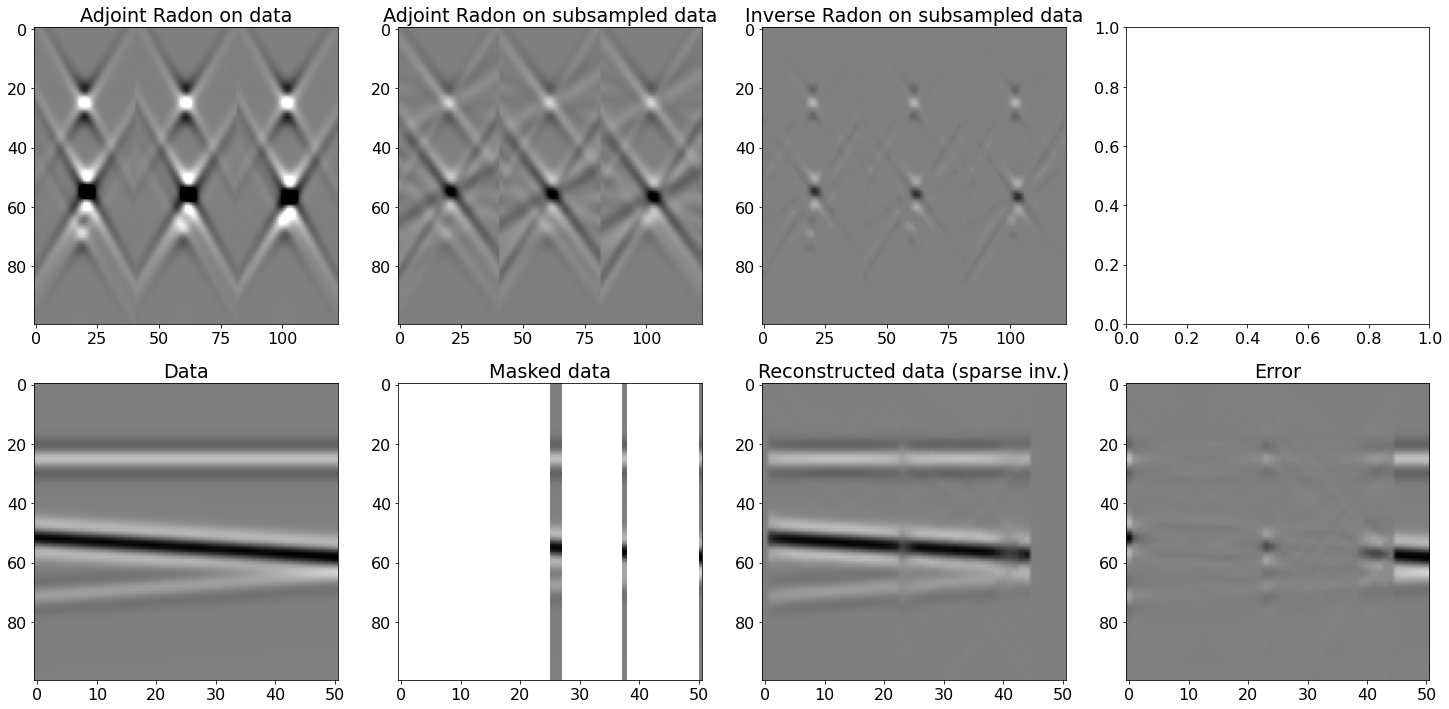

In [26]:
xinvf, pinvf, _ = SeismicInterpolation(y, (par['ny'], par['nx']), iava, kind='sliding', 
                                       spataxis=yaxis, spat1axis=xaxis, 
                                       taxis=taxis, paxis=py, p1axis=px, nwins=nwins, nwin=nwin, 
                                       nover=nover, dottest=False,
                                       **dict(niter=40, eps=5e0, alpha=1e-5, show=True))

fig, axs = plt.subplots(2, 4, figsize=(25, 12))
axs[0][0].imshow(padj_fromx[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-100, vmax=100)
axs[0][0].set_title('Adjoint Radon on data')
axs[0][0].axis('tight')
axs[0][1].imshow(padj[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-100, vmax=100)
axs[0][1].set_title('Adjoint Radon on subsampled data')
axs[0][1].axis('tight')
axs[0][2].imshow(pinvf[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-0.1, vmax=0.1)
axs[0][2].set_title('Inverse Radon on subsampled data')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1][0].set_title('Data')
axs[1][0].axis('tight');
axs[1][1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1][1].set_title('Masked data')
axs[1][1].axis('tight');
axs[1][2].imshow(xinvf[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1][2].set_title('Reconstructed data (sparse inv.)')
axs[1][2].axis('tight')
axs[1][3].imshow(x[:, par['nx']//2].T-xinvf[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1][3].set_title('Error')
axs[1][3].axis('tight');

## Linear events with subsampling in both directions

In [27]:
###### Input parameters
par = {'oy':0,'dy':2,    'ny':51,
       'ox':0,'dx':2,    'nx':30,
       'ot':0,'dt':0.004,'nt':100,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.1, 0.2, 0.3]
theta_m = [0, 30, -60]
phi_m   = [0, 50, 30]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear3d(xaxis, yaxis, taxis, v, t0_m, theta_m, phi_m, amp_m, wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['ny']*perc_subsampling))
Nsub1=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['ny']))[:Nsub])
iava1 = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub1])

# Create restriction operator
Rop0 = Restriction(dims=(par['ny'], par['nx'], par['nt']), iava=iava, 
                   axis=0, dtype='float64')
Rop1 = Restriction(dims=(Nsub, par['nx'], par['nt']), iava=iava1, 
                   axis=1, dtype='float64')
Rop1mask = Restriction(dims=(par['ny'], par['nx'], par['nt']), iava=iava1, 
                       axis=1, dtype='float64')

Rop  = Rop1*Rop0
dottest(Rop,Nsub*Nsub1*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, Nsub1, par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop1mask.mask(Rop0.mask(x.flatten()))

Dot test passed, v^H(Opu)=176.49552259209304 - u^H(Op^Hv)=176.49552259209304


Dot test passed, v^H(Opu)=277.36016099036965 - u^H(Op^Hv)=277.3601609903696


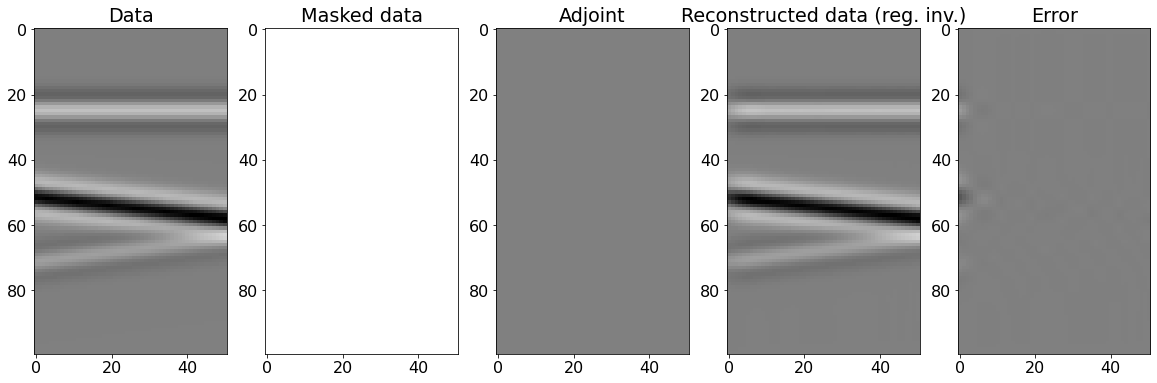

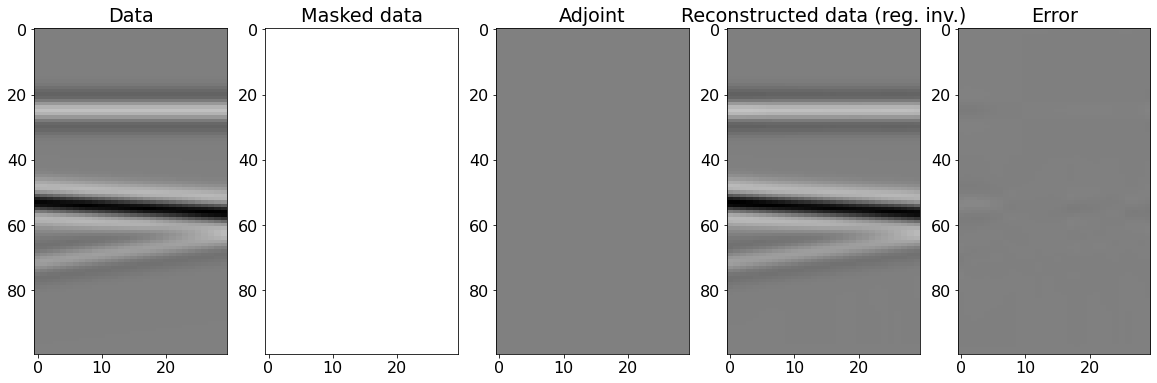

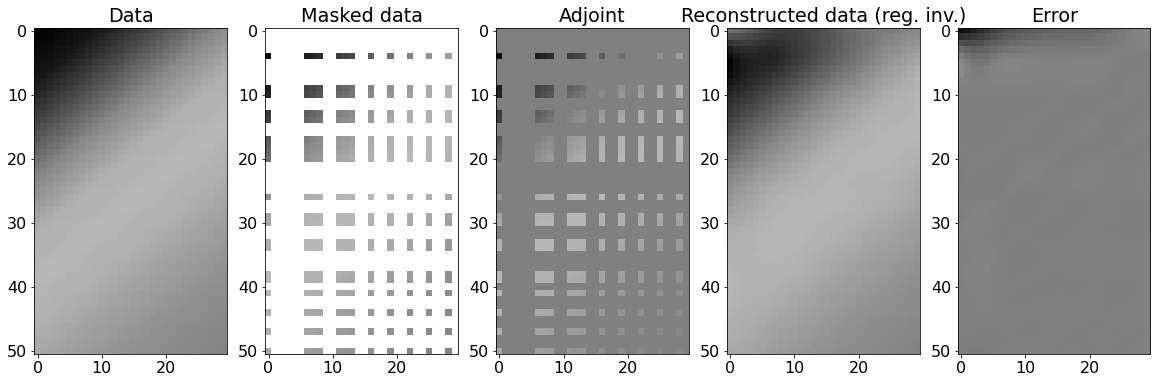

In [28]:
# Invert for interpolated signal
xinv, _, _ = SeismicInterpolation(y, (par['ny'], par['nx']), iava, iava1=iava1, kind='spatial', dottest=True,
                                  **dict(epsRs=[np.sqrt(0.1)],
                                         damp=np.sqrt(1e-4), iter_lim=100, show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[par['ny']//2].T-xinv[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[:, :, par['nt']//2], cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[:, :, par['nt']//2], cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[:, :, par['nt']//2], cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[:, :, par['nt']//2], cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[:, :, par['nt']//2]-xinv[:, :, par['nt']//2], cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

## Realistic data

In [29]:
inputfile3d = '../data/seismicinterpolation/input3d.npz'
inputdata3d = np.load(inputfile3d)

x = np.transpose(inputdata3d['data'], (2, 1, 0))[:,:, :400:2]
x = x/np.abs(x).max()

taxis, xaxis, yaxis = inputdata3d['t'][:400:2], inputdata3d['rx'][:], inputdata3d['ry'][:]
par = {}
par['ny'], par['nx'], par['nt'] = x.shape
par['dx'] = inputdata3d['rx'][1] - inputdata3d['rx'][0]
par['dy'] = inputdata3d['ry'][1] - inputdata3d['ry'][0]
par['dt'] = inputdata3d['t'][1] - inputdata3d['t'][0]

# add wavelet
wav3d = wav[::3]
wav3d_c = np.argmax(wav3d)
x = np.apply_along_axis(convolve, 2, x, wav3d, mode='full')
x = x[:, :, wav3d_c:][:, :, :par['nt']]

# gain
gain = np.transpose(np.tile((taxis**2)[:, np.newaxis, np.newaxis], (1, par['ny'], par['nx'])), (1, 2, 0))
x = x*gain

# subsampling locations
perc_subsampling=0.6
Nsub=int(np.round(par['ny']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['ny']))[:Nsub])

# Create restriction operator
Rop = Restriction(dims=(par['ny'], par['nx'], par['nt']), iava=iava, 
                  axis=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=68.02066143271742 - u^H(Op^Hv)=68.02066143271861


### Inversion in time-space domain with spatial smoothing

Dot test passed, v^H(Opu)=-325.8545840449466 - u^H(Op^Hv)=-325.8545840449491


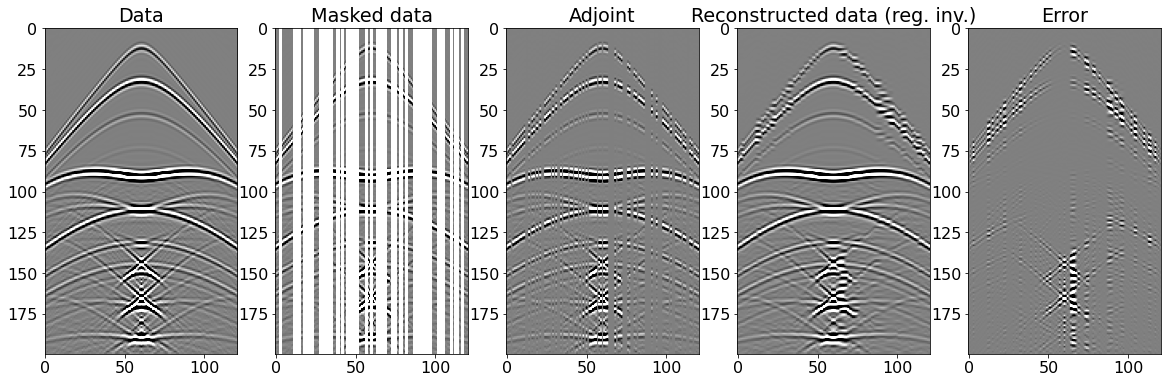

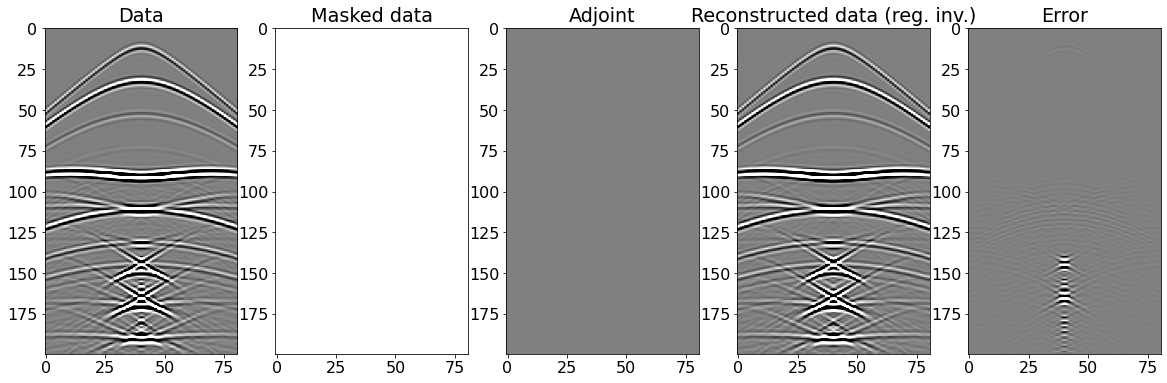

In [30]:
# Invert for interpolated signal
xinv, _, _ = SeismicInterpolation(y, (par['ny'], par['nx']), iava, kind='spatial', dottest=True,
                                  **dict(epsRs=[np.sqrt(0.1)],
                                         damp=np.sqrt(1e-4), iter_lim=100, show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[4].set_title('Error')
axs[4].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[par['ny']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[par['ny']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[par['ny']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[par['ny']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[par['ny']//2].T-xinv[par['ny']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

Dot test passed, v^H(Opu)=(-712.5164341328625-313.4773048445812j) - u^H(Op^Hv)=(-712.5164341328731-313.4773048445898j)
FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 1182600 rows and 16777216 cols
eps = 1.000000e-04	tol = 1.000000e-10	niter = 50
alpha = 1.000000e+00	thresh = 5.000000e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    9.418e-03   4.135e-01   2.521e+00
     2   -0.00e+00+0.00e+00j    9.036e-03   4.059e-01   6.203e-02
     3   -0.00e+00+0.00e+00j    8.701e-03   3.986e-01   6.884e-02
     4   -0.00e+00+0.00e+00j    8.433e-03   3.917e-01   7.411e-02
     5   -0.00e+00+0.00e+00j    8.216e-03   3.852e-01   7.815e-02
     6   -0.00e+00+0.00e+00j    8.033e-03   3.791e-01   8.112e-02
     7   -0.00e+00+0.00e+00j    7.876e-03   3.735e-01   8.315e-02
     8   -0.00e+00+0.00

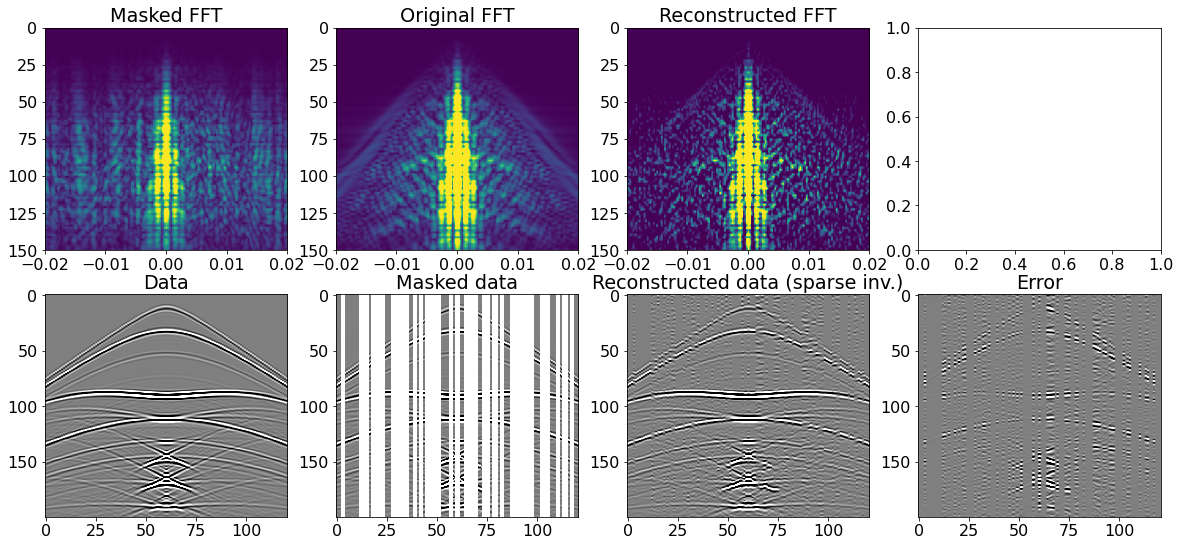

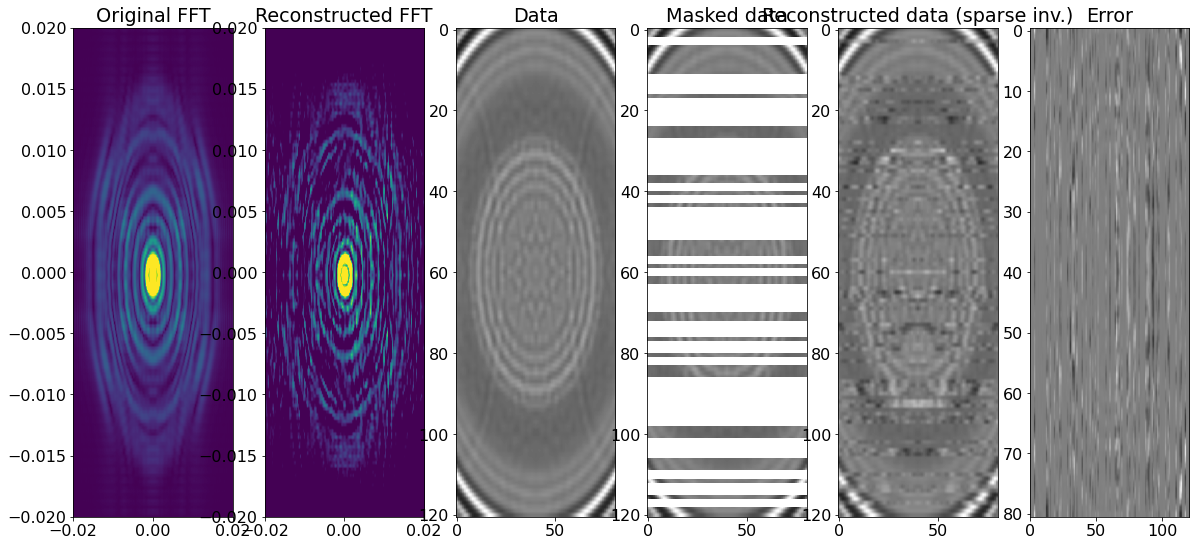

In [31]:
nfft=2**8
FFTop = FFTND(dims=[par['ny'], par['nx'], par['nt']], nffts=[nfft, nfft, nfft], 
              sampling=[par['dy'], par['dx'], par['dt']])
dottest(FFTop, nfft*nfft*nfft, par['ny']*par['nx']*par['nt'], complexflag=2, verb=True)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft, nfft))

pmask = FFTop*ymask.flatten()
pmask = np.reshape(pmask, (nfft, nfft, nfft))

# Inverse
xinv, pinv, _ = SeismicInterpolation(y, (par['ny'], par['nx']), iava, kind='fk', nffts=(nfft, nfft, nfft), 
                                     sampling=(par['dy'], par['dx'], par['dt']), dottest=False,
                                     **dict(niter=50, eps=1e-4, alpha=1, show=True))

fig, axs = plt.subplots(2, 4, figsize=(20, 9))
axs[0][0].imshow(np.fft.fftshift(np.abs(pmask[:, 1, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=0.01)
axs[0][0].set_title('Masked FFT')
axs[0][0].axis('tight')
axs[0][0].set_ylim(150, 0)
axs[0][0].set_xlim(-0.02, 0.02)
axs[0][1].imshow(np.fft.fftshift(np.abs(p[:, 1, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=0.01)
axs[0][1].set_title('Original FFT')
axs[0][1].axis('tight')
axs[0][1].set_ylim(150, 0)
axs[0][1].set_xlim(-0.02, 0.02)
axs[0][2].imshow(np.fft.fftshift(np.abs(pinv[:, 1, :nfft//2-1]), axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=0.01)
axs[0][2].set_title('Reconstructed FFT')
axs[0][2].axis('tight')
axs[0][2].set_ylim(150, 0)
axs[0][2].set_xlim(-0.02, 0.02)
axs[1][0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][0].set_title('Data')
axs[1][0].axis('tight');
axs[1][1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][1].set_title('Masked data')
axs[1][1].axis('tight')
axs[1][2].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][2].set_title('Reconstructed data (sparse inv.)')
axs[1][2].axis('tight');
axs[1][3].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][3].set_title('Error')
axs[1][3].axis('tight');
                                  
fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(np.fft.fftshift(np.fft.fftshift(np.abs(p[:, :, 50]),axes=0),axes=1).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      np.fft.fftshift(FFTop.fs[1])[0], np.fft.fftshift(FFTop.fs[1])[-1]), 
              vmin=0, vmax=0.01)
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(-0.02, 0.02)
axs[0].set_xlim(-0.02, 0.02)
axs[1].imshow(np.fft.fftshift(np.fft.fftshift(np.abs(pinv[:, :, 50]),axes=0),axes=1).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      np.fft.fftshift(FFTop.fs[1])[0], np.fft.fftshift(FFTop.fs[1])[-1]), 
              vmin=0, vmax=0.01)
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(-0.02, 0.02)
axs[1].set_xlim(-0.02, 0.02)
axs[2].imshow(x[:, :, par['nt']//2], cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask[:, :, par['nt']//2], cmap='gray', vmin=-0.005, vmax=0.005)
axs[3].set_title('Masked data')
axs[3].axis('tight')
axs[4].imshow(xinv[:, :, par['nt']//2], cmap='gray', vmin=-0.005, vmax=0.005)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x[:, :, par['nt']//2].T-xinv[:, :, par['nt']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[5].set_title('Error')
axs[5].axis('tight');

### Inversion in parabolic Radon domain with sparsity-promoting solver

In [32]:
npy=npx=61
pxmax = 8e-6
px = np.linspace(-pxmax/2, pxmax, npx)
Radop = Radon3D(taxis, yaxis, xaxis, px, px, centeredh=True, kind='parabolic', 
                onthefly=True, engine='numba')
dottest(Radop, par['ny']*par['nx']*par['nt'], npy*npx*par['nt'], verb=True);

Dot test passed, v^H(Opu)=47053.821405412156 - u^H(Op^Hv)=47053.82140541209


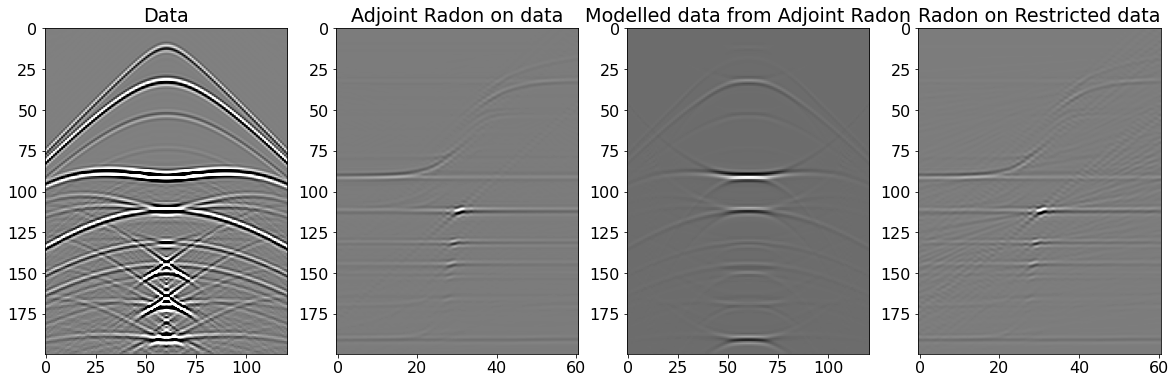

In [33]:
Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['ny'], par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npy, npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj[:, npx//2].T, cmap='gray', interpolation='sinc')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj[:, par['nx']//2].T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj[:, npx//2].T, cmap='gray', interpolation='sinc')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

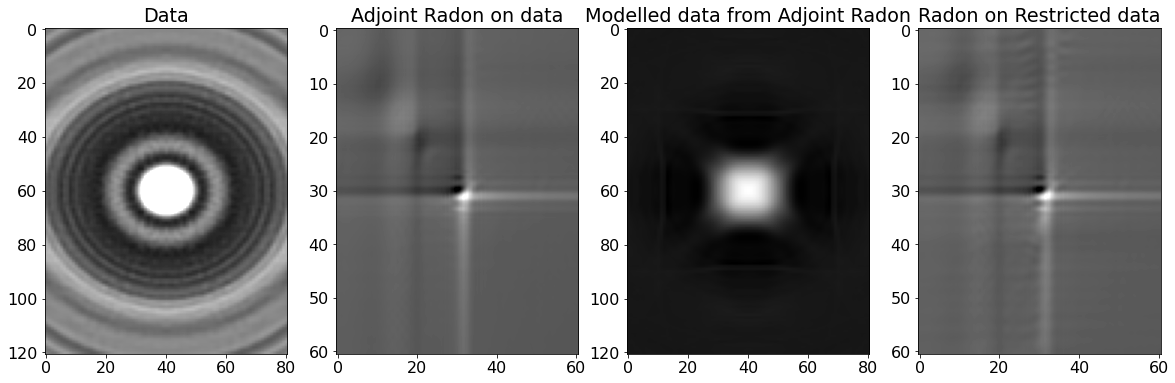

In [34]:
it = 110

fig, axs= plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x[:, :, it], cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj[:, :, it], cmap='gray', interpolation='sinc')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj[:, :, it], cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj[:, :, it], cmap='gray', interpolation='sinc')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 1182600 rows and 744200 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 30
alpha = 4.756957e-08	thresh = 2.378478e-11
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         3.354e+00   3.354e+00   4.257e-05
     2       0.0000e+00         3.318e+00   3.318e+00   4.186e-05
     3       0.0000e+00         3.272e+00   3.272e+00   5.277e-05
     4       0.0000e+00         3.220e+00   3.220e+00   6.287e-05
     5       0.0000e+00         3.161e+00   3.161e+00   7.223e-05
     6       0.0000e+00         3.097e+00   3.097e+00   8.089e-05
     7       0.0000e+00         3.028e+00   3.029e+00   8.886e-05
     8       0.0000e+00         2.957e+00   2.957e+00   9.616e-05
     9       0.0000e+00         2.884e+00   2.884e+00   1.028e-04
    10      

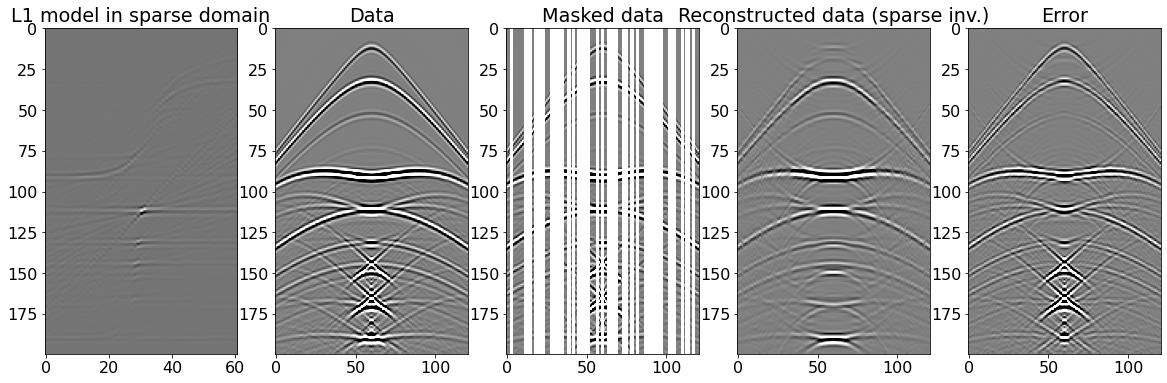

In [35]:
xinv, pinv, cost = SeismicInterpolation(y, (par['ny'], par['nx']), 
                                        iava, kind='radon-parabolic', spataxis=yaxis, spat1axis=xaxis, 
                                        taxis=taxis, paxis=px, p1axis=px, centeredh=True, dottest=False,
                                        **dict(niter=30, alpha=4.756957e-08, eps=1e-3, show=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pinv[:, npx//2].T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[4].set_title('Error')
axs[4].axis('tight');

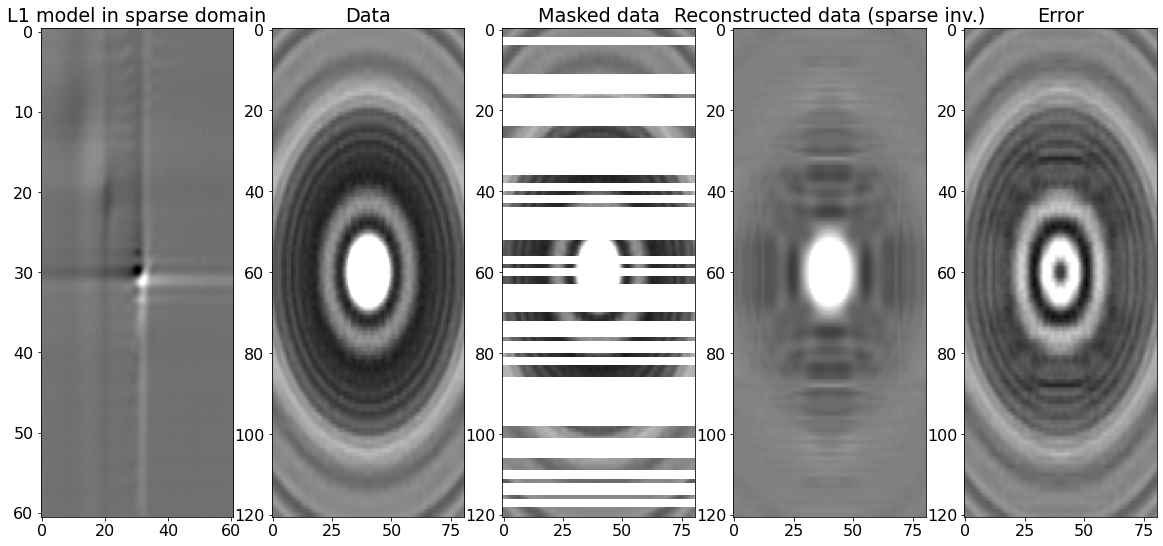

In [36]:
fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(pinv[:, :, it], cmap='gray', interpolation='sinc')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x[:, :, it], cmap='gray', vmin=-0.005, vmax=0.005)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask[:, :, it], cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinv[:, :, it], cmap='gray', vmin=-0.005, vmax=0.005)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x[:, :, it]-xinv[:, :, it], cmap='gray', vmin=-0.005, vmax=0.005)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in sliding linear Radon domain with sparsity-promoting solver

In [38]:
dy = par['dy']
dx = par['dx']
nwin=(21, 19)
nwins=(7, 5)
nover=(6, 5)
npy=41
npx=41
pxmax = 5e-4
py = px = np.linspace(-pxmax, pxmax, npx)
dimsd = (par['ny'], par['nx'], par['nt'])
dims = (nwins[0]*npy, nwins[1]*npx, dimsd[2])

# sliding window radon with overlap
Op = Radon3D(taxis, np.linspace(-dy*nwin[0]//2, dy*nwin[0]//2, nwin[0]), 
             np.linspace(-dx*nwin[1]//2, dx*nwin[1]//2, nwin[1]), 
             px, px, centeredh=True,
             kind='linear', engine='numba')
Slidop = Sliding3D(Op, dims, dimsd, nwin, nover, (npy, npx), tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims), verb=True)

# adjoint
Rop1 = Rop*Slidop

padj_fromx = Slidop.H*x.flatten()
padj_fromx = padj_fromx.reshape(nwins[0], nwins[1], npy, npx, par['nt'])

padj = Rop1.H*y.flatten()
padj = padj.reshape(nwins[0], nwins[1], npy, npx, par['nt'])

Dot test passed, v^H(Opu)=18380.766609508075 - u^H(Op^Hv)=18380.766609508286


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 1182600 rows and 11767000 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 40
alpha = 1.100000e-05	thresh = 5.500000e-07
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -0.0000e+00         3.325e+00   3.347e+00   7.901e-04
     2      -0.0000e+00         3.262e+00   3.304e+00   7.699e-04
     3      -0.0000e+00         3.184e+00   3.252e+00   9.626e-04
     4      -0.0000e+00         3.095e+00   3.193e+00   1.136e-03
     5      -0.0000e+00         2.997e+00   3.129e+00   1.293e-03
     6      -0.0000e+00         2.892e+00   3.062e+00   1.433e-03
     7      -0.0000e+00         2.783e+00   2.992e+00   1.556e-03
     8      -0.0000e+00         2.672e+00   2.923e+00   1.664e-03
     9      -0.0000e+00         2.559e+00   2.854e+00   1.757e-03
    10    

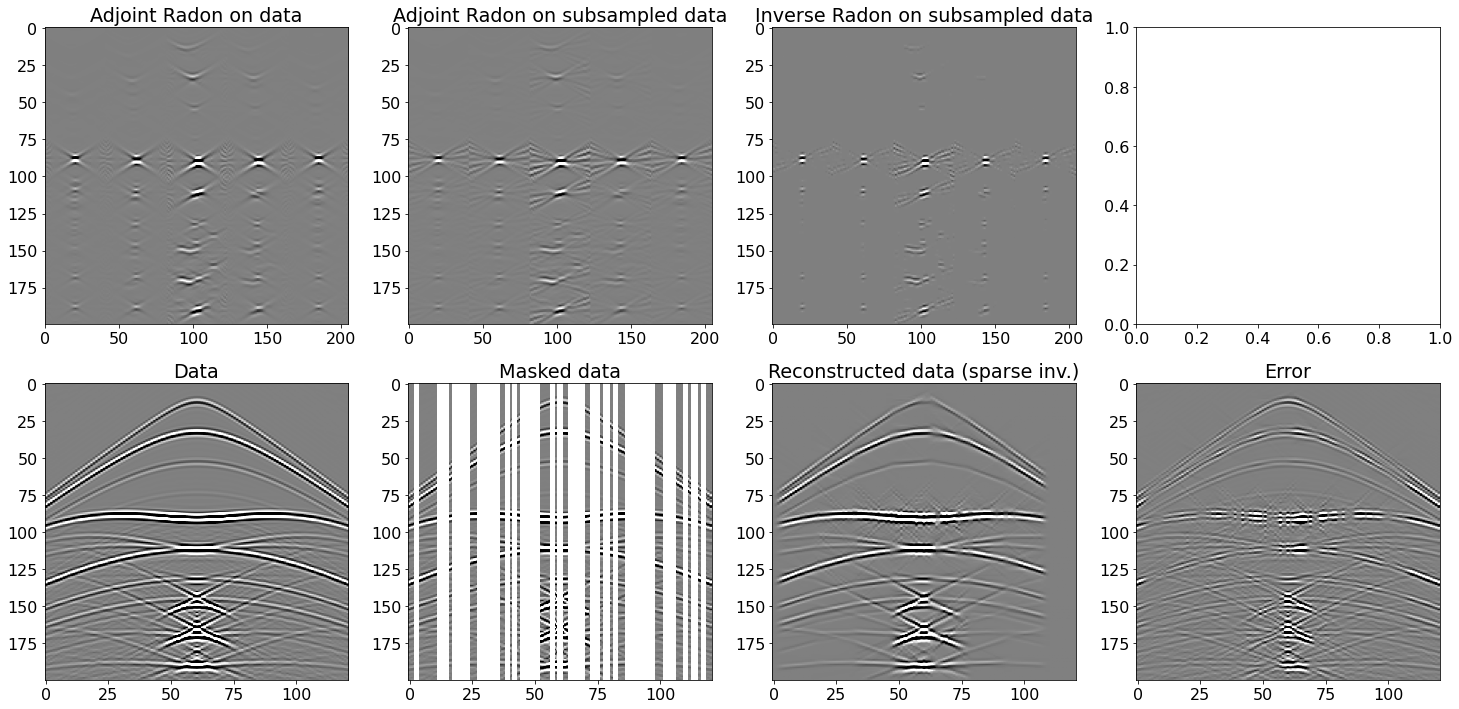

In [39]:
xinv, pinv, cost = SeismicInterpolation(y, (par['ny'], par['nx']), iava, kind='sliding', 
                                        spataxis=yaxis, spat1axis=xaxis, 
                                        taxis=taxis, paxis=py, p1axis=px, nwins=nwins, nwin=nwin, 
                                        nover=nover, dottest=False,
                                        **dict(niter=40, alpha=1.1e-5, eps=1e-1, show=True))

fig, axs = plt.subplots(2, 4, figsize=(25, 12))
axs[0][0].imshow(padj_fromx[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('Adjoint Radon on data')
axs[0][0].axis('tight')
axs[0][1].imshow(padj[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-1, vmax=1)
axs[0][1].set_title('Adjoint Radon on subsampled data')
axs[0][1].axis('tight')
axs[0][2].imshow(pinv[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-0.001, vmax=0.001)
axs[0][2].set_title('Inverse Radon on subsampled data')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][0].set_title('Data')
axs[1][0].axis('tight');
axs[1][1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][1].set_title('Masked data')
axs[1][1].axis('tight');
axs[1][2].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][2].set_title('Reconstructed data (sparse inv.)')
axs[1][2].axis('tight')
axs[1][3].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][3].set_title('Error')
axs[1][3].axis('tight');

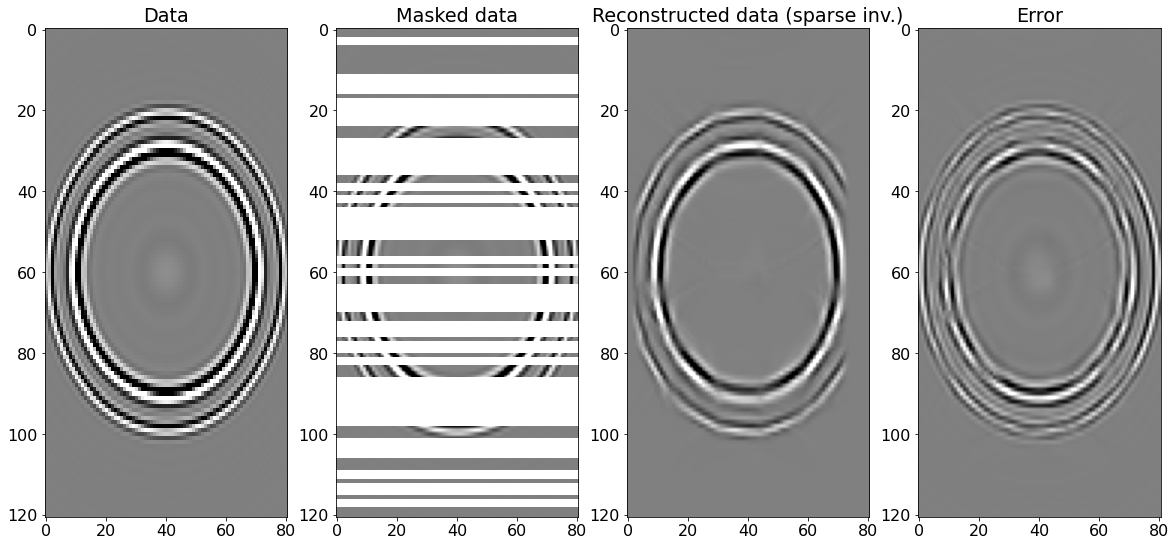

In [40]:
fig, axs = plt.subplots(1, 4, figsize=(20, 9))
axs[0].imshow(x[:, :, par['nt']//4], cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('Data')
axs[0].axis('tight');
axs[1].imshow(ymask[:, :, par['nt']//4], cmap='gray', vmin=-0.005, vmax=0.005)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xinv[:, :, par['nt']//4], cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Reconstructed data (sparse inv.)')
axs[2].axis('tight');
axs[3].imshow(x[:, :, par['nt']//4]-xinv[:, :, par['nt']//4], cmap='gray', vmin=-0.005, vmax=0.005)
axs[3].set_title('Error')
axs[3].axis('tight');

Finally we repeat the same exercise but with an regular coarse sampling along y axis

In [42]:
# subsampling locations
iava = np.arange(0, par['ny'], 5)
Nsub = len(iava)

# Create restriction operator
Rop = Restriction(iava=iava, 
                  dims=(par['ny'], par['nx'], par['nt']), axis=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=1184.8581029598504 - u^H(Op^Hv)=1184.8581029598508


In [44]:
dy = par['dy']
dx = par['dx']
nwin=(21, 19)
nwins=(7, 5)
nover=(5, 5)
npy=41
npx=41
pxmax = 5e-4
py = px = np.linspace(-pxmax, pxmax, npx)
dimsd = (par['ny'], par['nx'], par['nt'])
dims = (nwins[0]*npy, nwins[1]*npx, dimsd[2])

# sliding window radon with overlap
Op = Radon3D(taxis, np.linspace(-dy*nwin[0]//2, dy*nwin[0]//2, nwin[0]), 
             np.linspace(-dx*nwin[1]//2, dx*nwin[1]//2, nwin[1]), 
             px, px, centeredh=True, kind='linear', engine='numba')
Slidop = Sliding3D(Op, dims, dimsd, nwin, nover, (npy, npx), tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims), verb=True)

# adjoint
Rop1 = Rop*Slidop

padj_fromx = Slidop.H*x.flatten()
padj_fromx = padj_fromx.reshape(nwins[0], nwins[1], npy, npx, par['nt'])

padj = Rop1.H*y.flatten()
padj = padj.reshape(nwins[0], nwins[1], npy, npx, par['nt'])

Dot test passed, v^H(Opu)=-69571.66335300544 - u^H(Op^Hv)=-69571.66335300512


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 405000 rows and 11767000 cols
eps = 5.000000e-02	tol = 1.000000e-10	niter = 50
alpha = 2.030948e-06	thresh = 5.077370e-08
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -0.0000e+00         1.168e+00   1.169e+00   7.138e-05
     2      -0.0000e+00         1.164e+00   1.167e+00   7.118e-05
     3      -0.0000e+00         1.160e+00   1.165e+00   9.097e-05
     4      -0.0000e+00         1.155e+00   1.162e+00   1.101e-04
     5      -0.0000e+00         1.150e+00   1.159e+00   1.287e-04
     6      -0.0000e+00         1.143e+00   1.155e+00   1.469e-04
     7      -0.0000e+00         1.136e+00   1.151e+00   1.646e-04
     8      -0.0000e+00         1.128e+00   1.147e+00   1.820e-04
     9      -0.0000e+00         1.119e+00   1.142e+00   1.990e-04
    10     

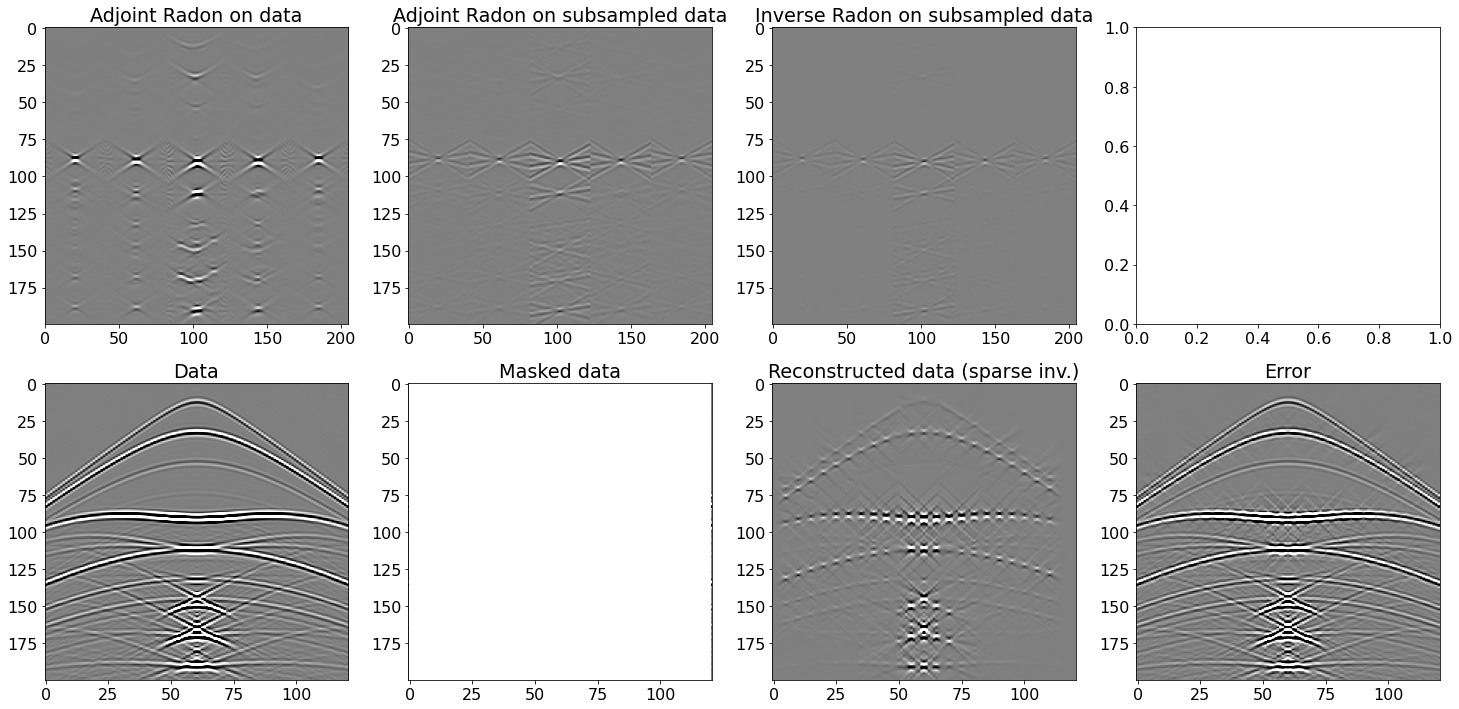

In [45]:
xinv, pinv, cost = SeismicInterpolation(y, (par['ny'], par['nx']), iava, kind='sliding', 
                                        spataxis=yaxis, spat1axis=xaxis, 
                                        taxis=taxis, paxis=py, p1axis=px, nwins=nwins, nwin=nwin, 
                                        nover=nover, dottest=False,
                                        **dict(niter=50, alpha=2.030948e-6,
                                             eps=5e-2, show=True))

fig, axs = plt.subplots(2, 4, figsize=(25, 12))
axs[0][0].imshow(padj_fromx[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('Adjoint Radon on data')
axs[0][0].axis('tight')
axs[0][1].imshow(padj[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-1, vmax=1)
axs[0][1].set_title('Adjoint Radon on subsampled data')
axs[0][1].axis('tight')
axs[0][2].imshow(pinv[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npy, par['nt']).T, 
                 cmap='gray', vmin=-0.001, vmax=0.001)
axs[0][2].set_title('Inverse Radon on subsampled data')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][0].set_title('Data')
axs[1][0].axis('tight');
axs[1][1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][1].set_title('Masked data')
axs[1][1].axis('tight');
axs[1][2].imshow(xinv[:, par['nx']//2]. T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][2].set_title('Reconstructed data (sparse inv.)')
axs[1][2].axis('tight')
axs[1][3].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[1][3].set_title('Error')
axs[1][3].axis('tight');

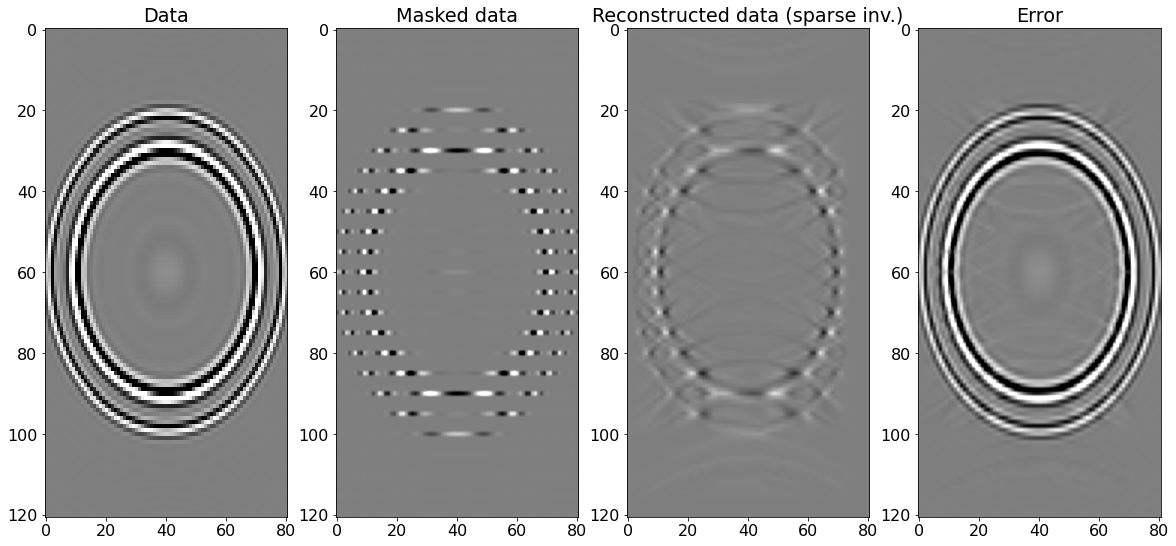

In [47]:
fig, axs = plt.subplots(1, 4, figsize=(20, 9))
axs[0].imshow(x[:, :, par['nt']//4], cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('Data')
axs[0].axis('tight');
axs[1].imshow(ymask.data[:, :, par['nt']//4], cmap='gray', vmin=-0.005, vmax=0.005)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xinv[:, :, par['nt']//4], cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Reconstructed data (sparse inv.)')
axs[2].axis('tight');
axs[3].imshow(x[:, :, par['nt']//4]-xinv[:, :, par['nt']//4], cmap='gray', vmin=-0.005, vmax=0.005)
axs[3].set_title('Error')
axs[3].axis('tight');